In [9]:
import pandas as pd
import argparse
import warnings
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.offline as offline
from IPython.display import display
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 120)
pd.set_option('display.expand_frame_repr', True)
import pandas as pd
from scipy import stats

In [10]:


origin_file = f'knockouts_measures.csv'
df_ori = pd.read_csv(origin_file)

original = 'o' # without knockout
keys = ['experiment_name', 'run', 'gen', 'ranking', 'individual_id', 'geno_size']
traits = ['disp_y', 'extremities_prop', 'distance','symmetry','proportion','coverage','extensiveness_prop','hinge_prop','modules_count','head_balance']

others = ['knockout']
df = df_ori.filter(items=keys+others+traits)

# df = df[
#     ( ( df['experiment_name'] == 'reg2m2') & (df['run'] == 1) &  (df['gen'] == 0 )  ) ]

df = df[(   ((df['gen'] == 0 ) |  (df['gen'] == 100 ))  )]


display(df)


,experiment_name,run,gen,ranking,individual_id,geno_size,knockout,disp_y,extremities_prop,distance,symmetry,proportion,coverage,extensiveness_prop,hinge_prop,modules_count,head_balance
0,reg2m2,1,0,best,38,151,o,1.0622070432,0.0714285714,0,0.0000000000,0.0500000000,1.0000000000,1.0000000000,1.0000000000,20,0.6235221137
1,reg2m2,1,0,best,38,151,0,-0.0000000065,0.9285714286,37,0.8333333333,0.3750000000,0.8333333333,0.0000000000,0.0000000000,20,0.9999975689
2,reg2m2,1,0,best,38,151,1,1.0622070432,0.0714285714,0,0.0000000000,0.0500000000,1.0000000000,1.0000000000,1.0000000000,20,0.6235221137
3,reg2m2,1,0,best,38,151,2,1.0622070432,0.0714285714,0,0.0000000000,0.0500000000,1.0000000000,1.0000000000,1.0000000000,20,0.6235221137
4,reg2m2,1,0,best,38,151,3,1.0622070432,0.0714285714,0,0.0000000000,0.0500000000,1.0000000000,1.0000000000,1.0000000000,20,0.6235221137
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1407031,reg10m2,30,100,worst,10073,243,30.32,0.0580949037,1.0000000000,0,1.0000000000,0.7500000000,0.5000000000,0.2500000000,1.0000000000,6,0.9822996780
1407032,reg10m2,30,100,worst,10073,243,30.33,0.0580949037,1.0000000000,0,1.0000000000,0.7500000000,0.5000000000,0.2500000000,1.0000000000,6,0.9822996780
1407033,reg10m2,30,100,worst,10073,243,31.32,0.0010767350,1.0000000000,1,1.0000000000,1.0000000000,0.5555555556,0.0000000000,1.0000000000,5,0.9904646199
1407034,reg10m2,30,100,worst,10073,243,31.33,0.0010767350,1.0000000000,1,1.0000000000,1.0000000000,0.5555555556,0.0000000000,1.0000000000,5,0.9904646199


In [ ]:
 
for trait in traits:
    # sends trait values of each knockout to columns
    pivot_df = df.pivot_table(index=keys,
                              columns='knockout', values=trait, # for distance variable, which is not a trait, the calculation is idle (comapared to 0) 
                              aggfunc='first')  
   
    all_columns = pivot_df.columns
    knock_columns = [col for col in all_columns if col not in keys and col != original]
    # Subtract each knock_columns by the original (positive values mean the mutant had an increse in the trait or growth)
    df_delta = pivot_df.drop(columns=original).sub(pivot_df[original], axis=0)

    double_knocks = [col for col in knock_columns if '.' in col]
    for double_knock in double_knocks:
        genes = double_knock.split('.')
        
        additive = df_delta[genes[0]] + df_delta[genes[1]]
        df_delta[f'{genes[0]}add{genes[1]}'] = additive
        df_delta[f'{genes[0]}int{genes[1]}'] = df_delta[double_knock] - additive
 
    int_columns = [col for col in df_delta.columns if 'int' in col]
    positive = df_delta[int_columns] > 0
    neutral = df_delta[int_columns] == 0
    negative = df_delta[int_columns] < 0
 
    is_finite = np.isfinite(df_delta[int_columns])

    positive = positive & is_finite
    neutral = neutral & is_finite
    negative = negative & is_finite

    count_positive = positive.sum(axis=1)
    count_neutral = neutral.sum(axis=1)
    count_negative = negative.sum(axis=1)
 
    df_delta['positive'] = count_positive
    df_delta['neutral'] = count_neutral
    df_delta['negative'] = count_negative
    df_delta['total'] = count_positive+count_neutral+count_negative
        
    df_delta['positive'] = df_delta['positive']/df_delta['total']
    df_delta['neutral'] = df_delta['neutral']/df_delta['total']
    df_delta['negative'] = df_delta['negative']/df_delta['total']
        
    positive_values = df_delta[int_columns].where(positive)
    negative_values = df_delta[int_columns].where(negative)

    positive_avg = positive_values.mean(axis=1, skipna=True)
    negative_avg = negative_values.mean(axis=1, skipna=True)
    df_delta['avg_positive'] = positive_avg
    df_delta['avg_negative'] = negative_avg

    df_exp=df_delta.reset_index()[keys+['positive','neutral','negative', 'avg_positive','avg_negative', 'total']]
    df_exp.to_csv(f'effects_{trait}.csv')
    
    print(trait)

In [149]:
clrs = ['#009900',
        '#EE8610',
        '#434699',
        '#95fc7a',
        '#221210',
        '#87ac65']

metrics = ['total',   'avg_positive',  'avg_negative']
traits = ['disp_y', 'extremities_prop', 'distance','symmetry','proportion','coverage','extensiveness_prop','hinge_prop','modules_count','head_balance']

keys = ['experiment_name', 'gen', 'ranking']

dfs_trait={}
for trait in traits:
    print('>>>>>',trait)
    dfs_trait[trait] = pd.read_csv(f'effects_{trait}.csv')
    dfs_trait[trait]['total'] = dfs_trait[trait]['positive'] + dfs_trait[trait]['negative']
    



>>>>> disp_y
>>>>> extremities_prop
>>>>> distance
>>>>> symmetry
>>>>> proportion
>>>>> coverage
>>>>> extensiveness_prop
>>>>> hinge_prop
>>>>> modules_count
>>>>> head_balance


>>>>>> disp_y
experiment_name    reg10m2
Name: 0, dtype: object


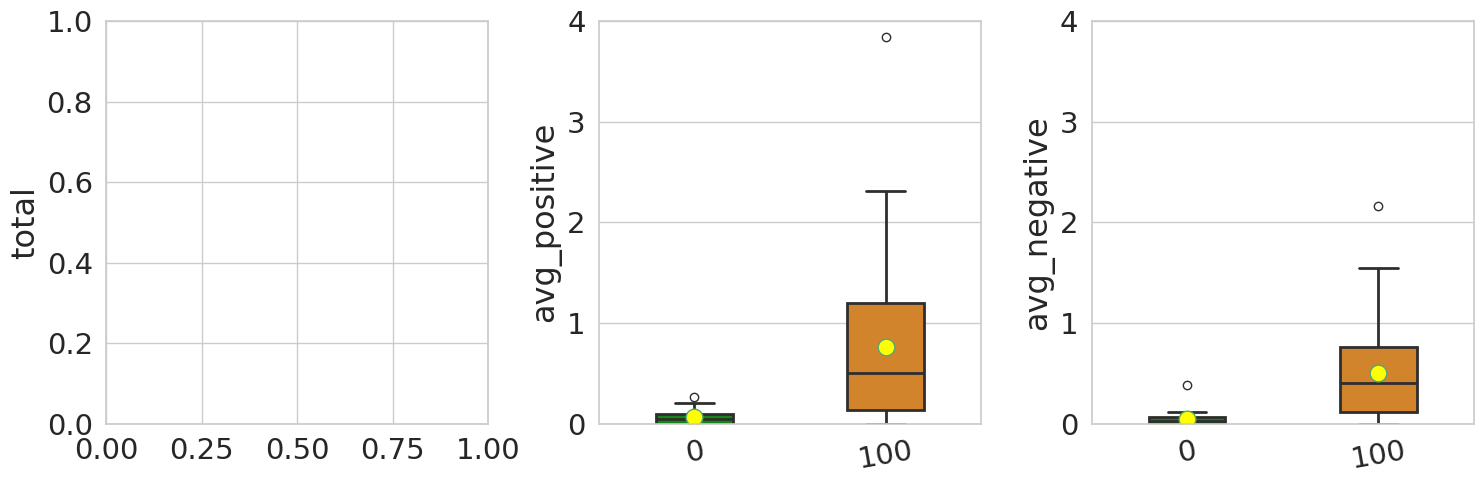

experiment_name    reg2m2
Name: 120, dtype: object


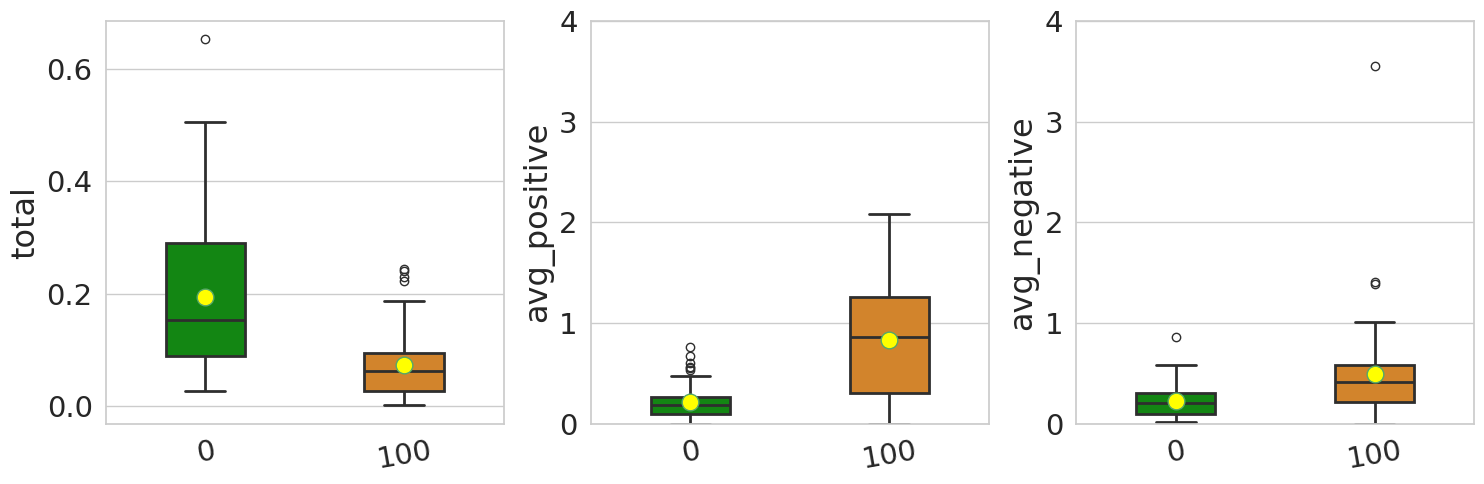

>>>>>> extremities_prop
experiment_name    reg10m2
Name: 0, dtype: object


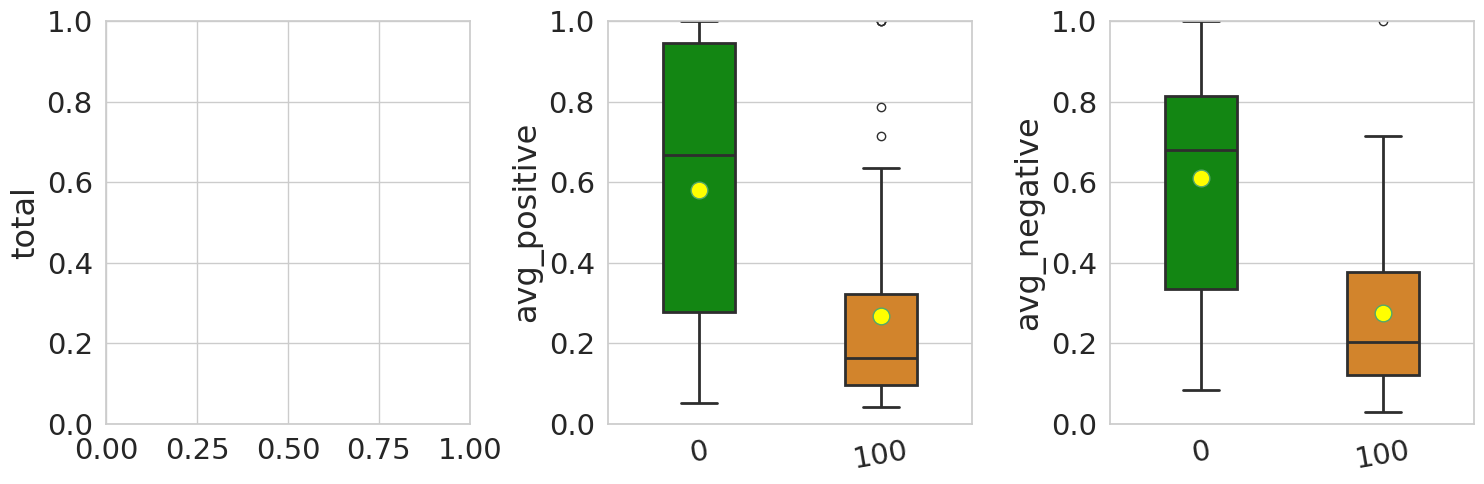

experiment_name    reg2m2
Name: 120, dtype: object


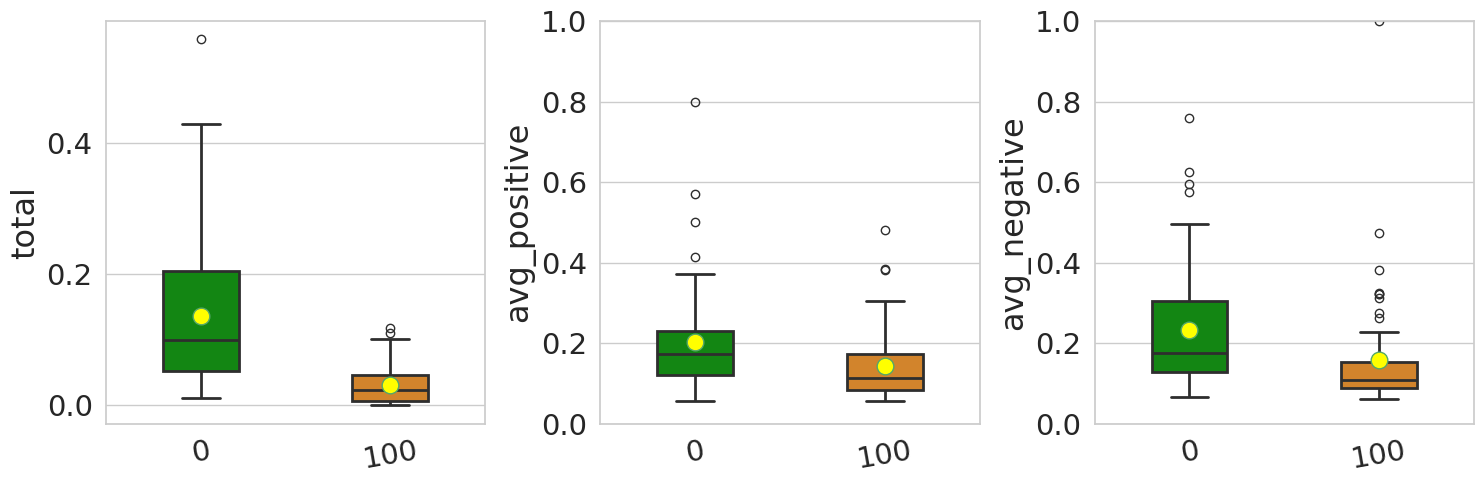

>>>>>> distance
experiment_name    reg10m2
Name: 0, dtype: object


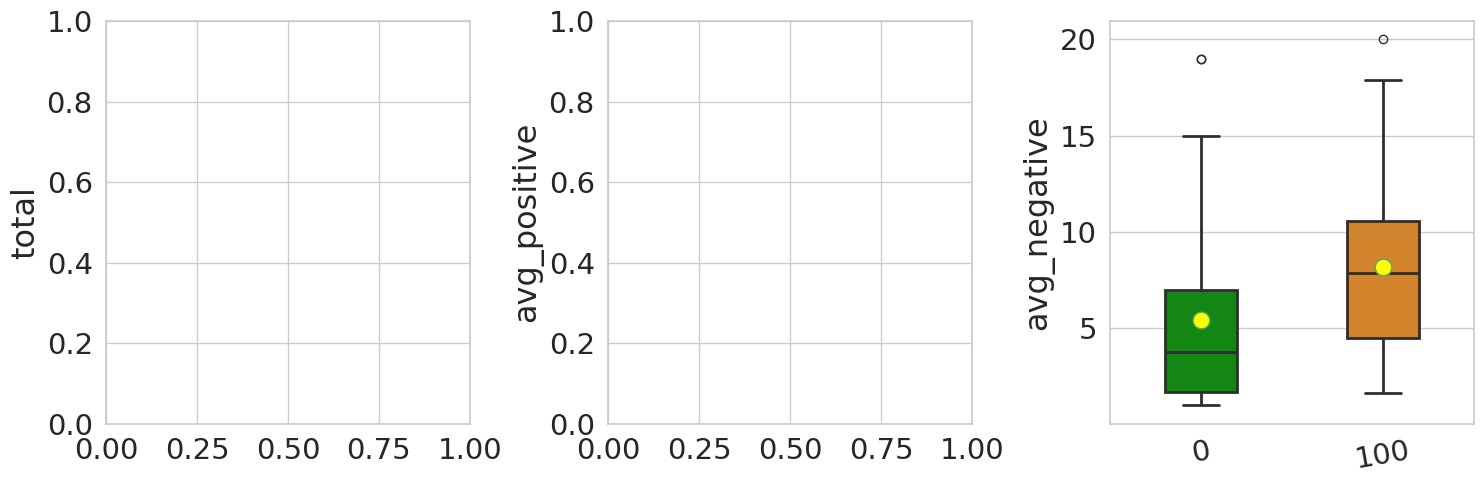

experiment_name    reg2m2
Name: 120, dtype: object


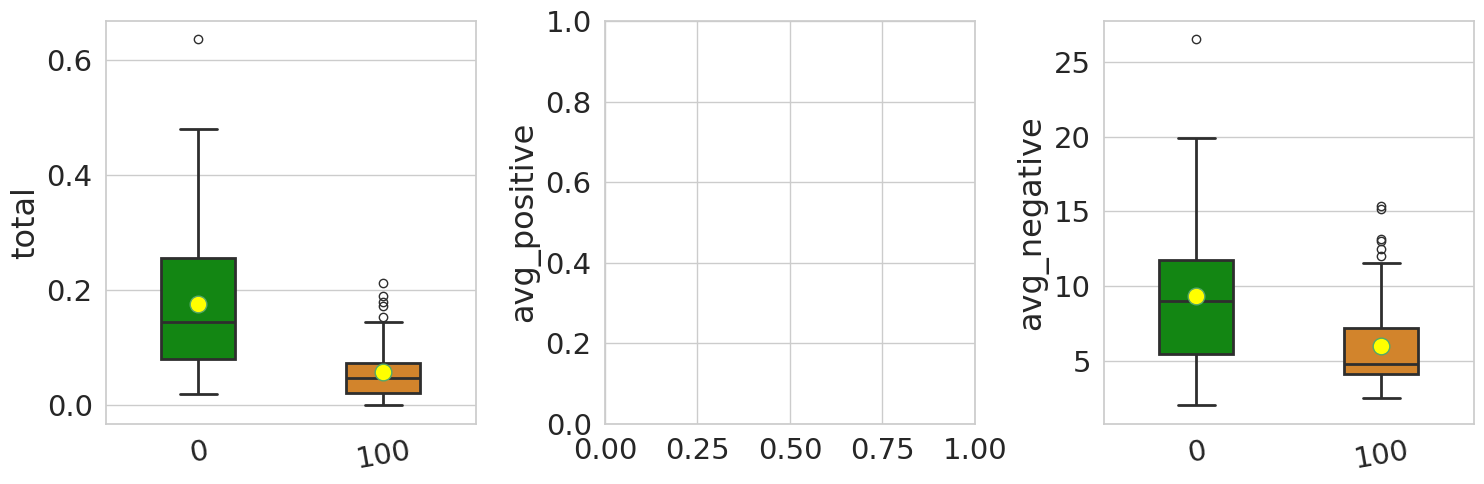

>>>>>> symmetry
experiment_name    reg10m2
Name: 0, dtype: object


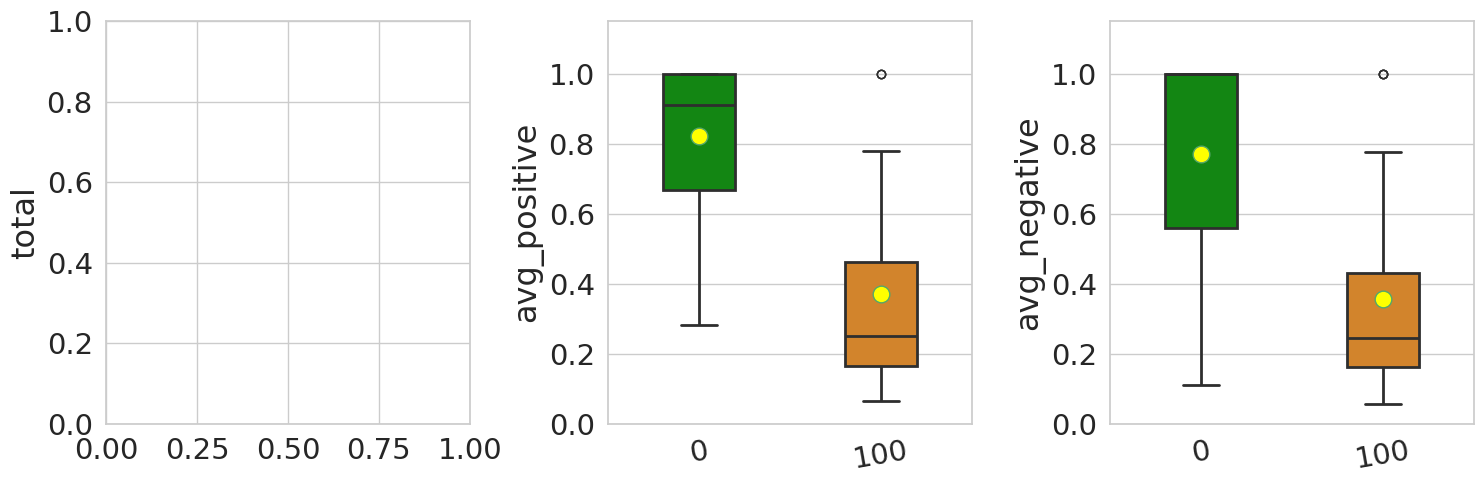

experiment_name    reg2m2
Name: 120, dtype: object


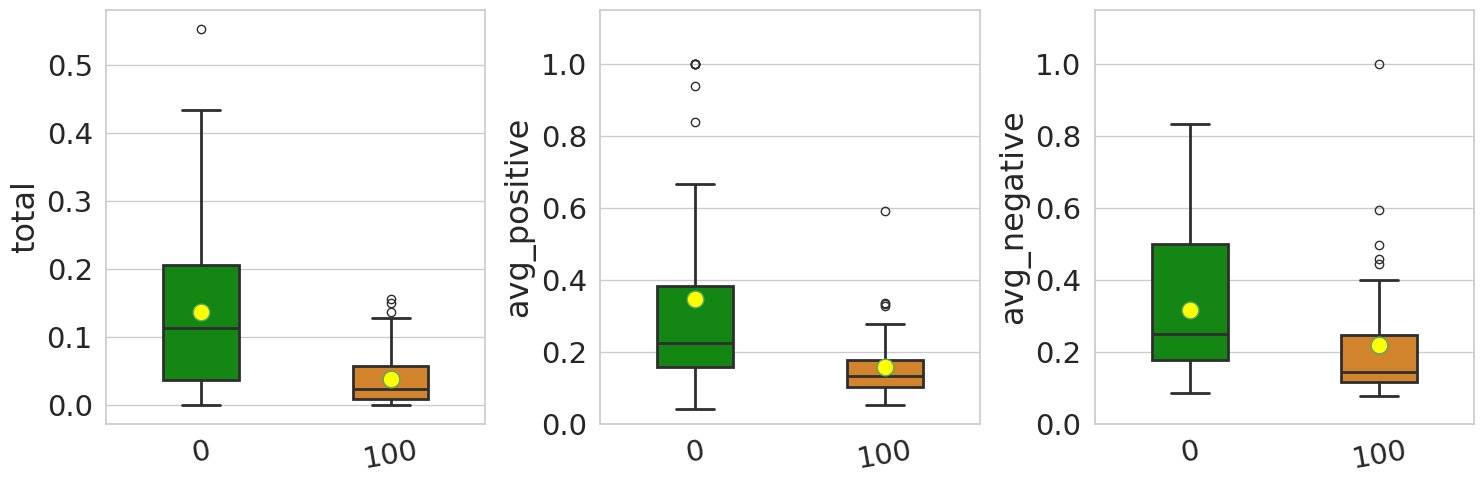

>>>>>> proportion
experiment_name    reg10m2
Name: 0, dtype: object


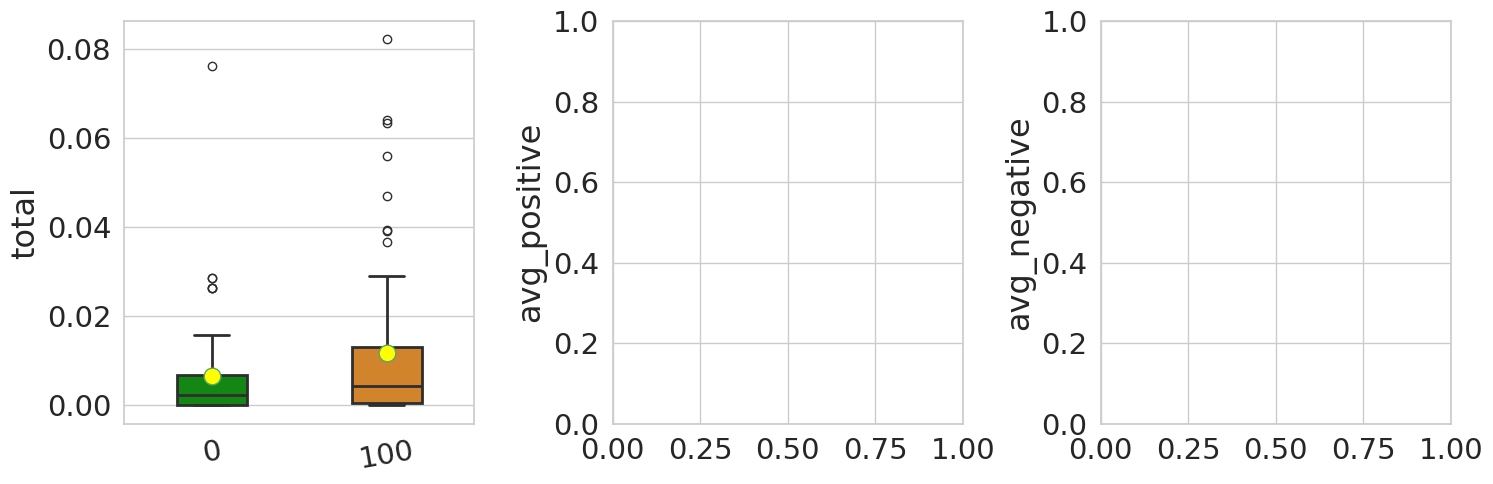

experiment_name    reg2m2
Name: 120, dtype: object


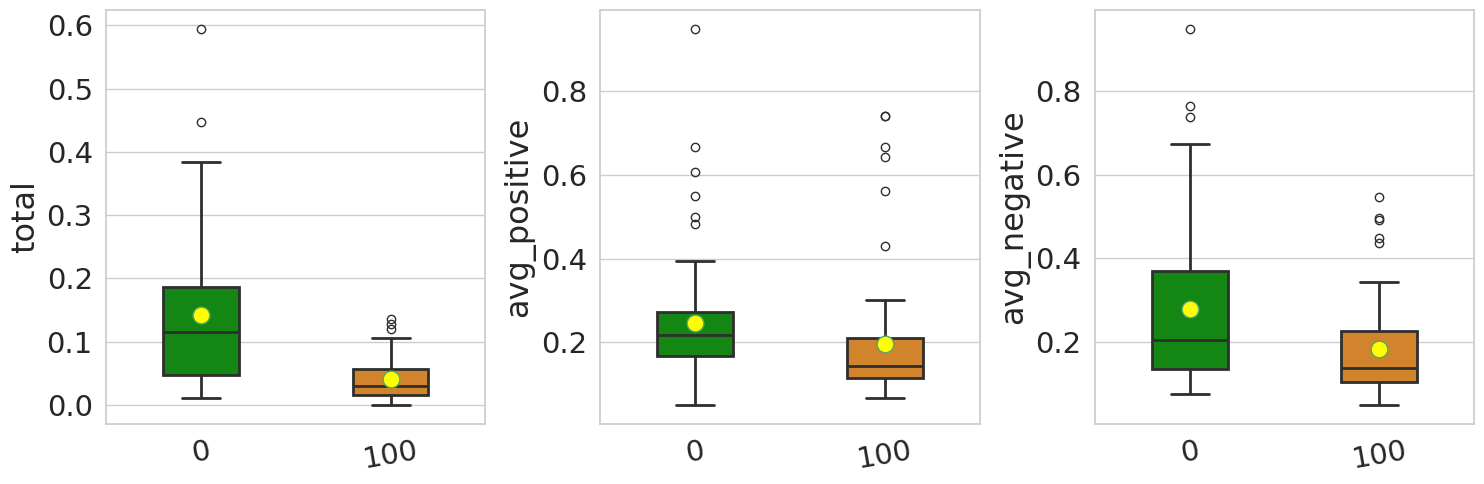

>>>>>> coverage
experiment_name    reg10m2
Name: 0, dtype: object


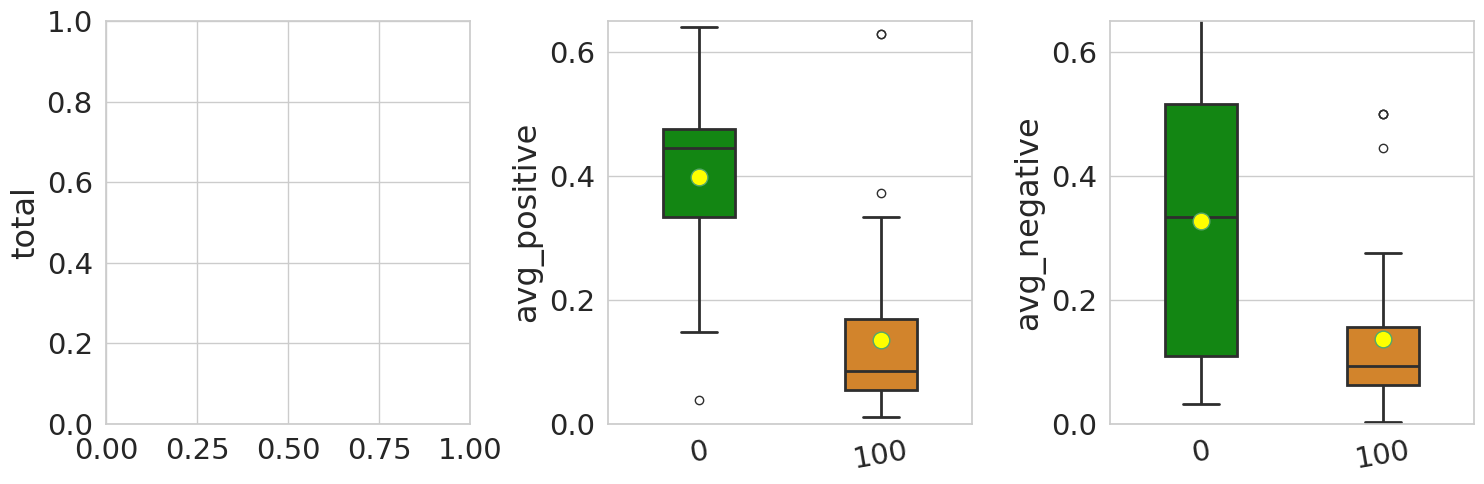

experiment_name    reg2m2
Name: 120, dtype: object


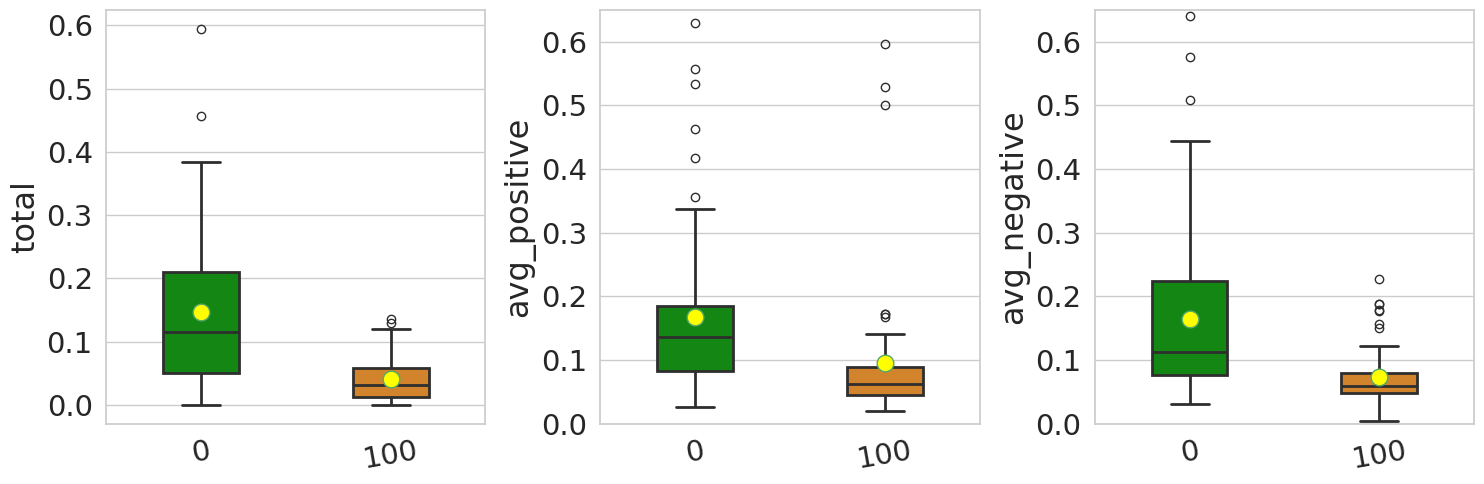

>>>>>> extensiveness_prop
experiment_name    reg10m2
Name: 0, dtype: object


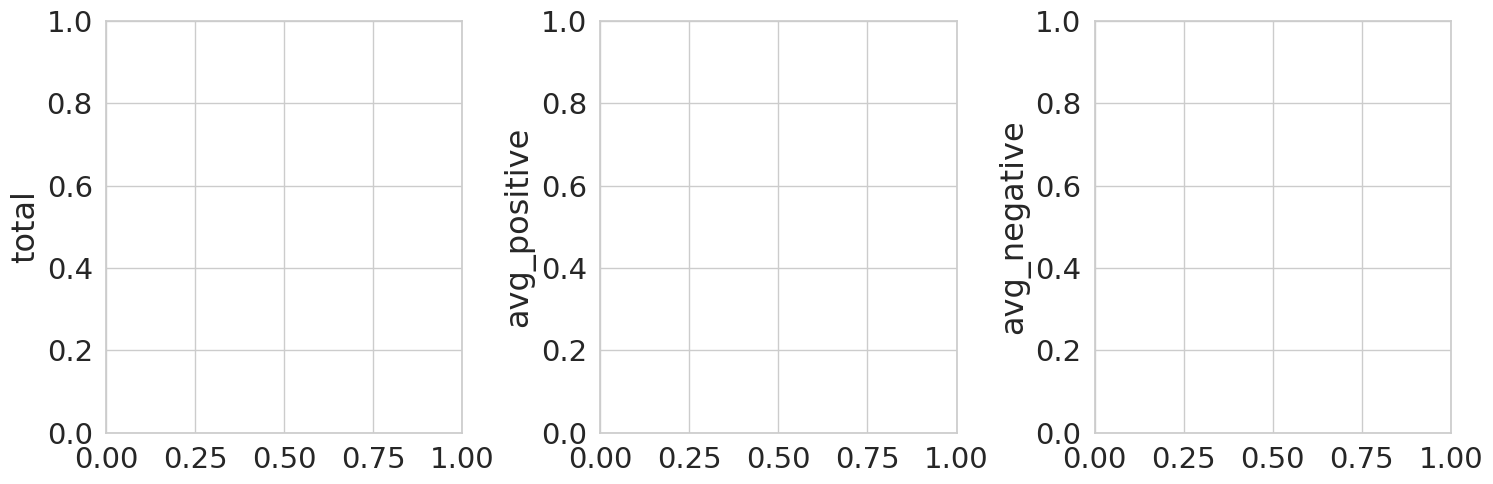

experiment_name    reg2m2
Name: 120, dtype: object


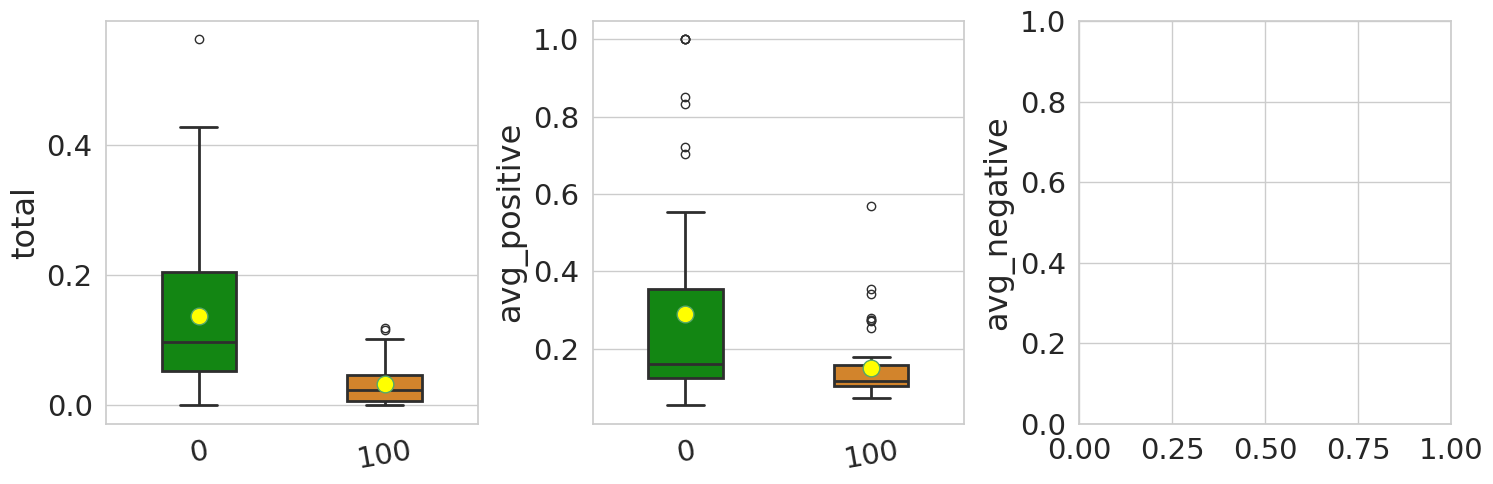

>>>>>> hinge_prop
experiment_name    reg10m2
Name: 0, dtype: object


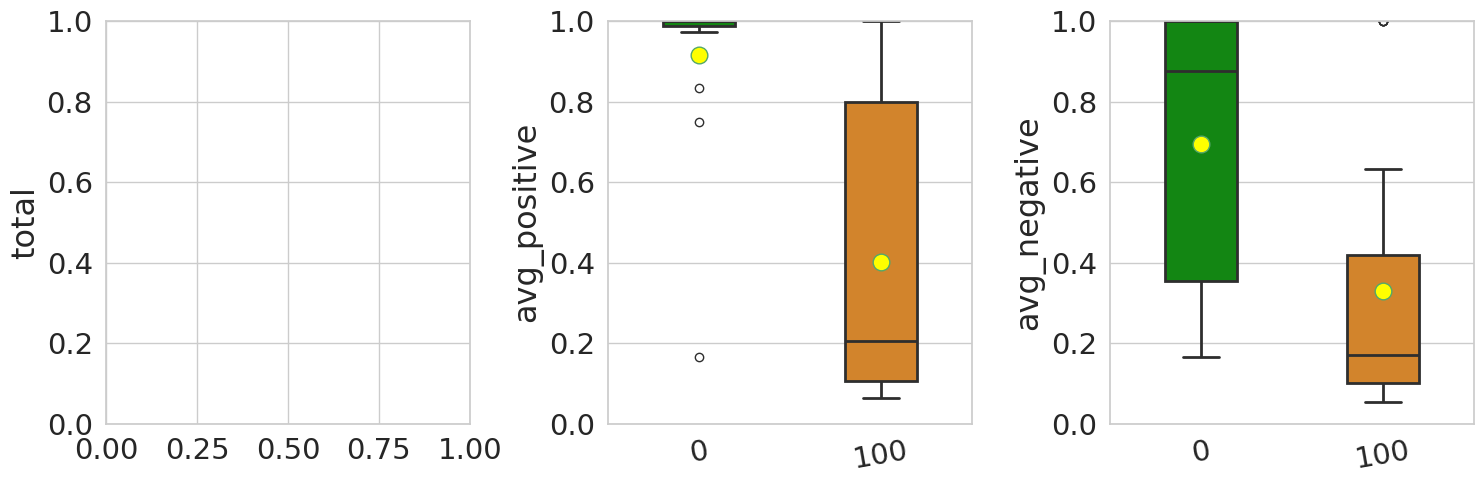

experiment_name    reg2m2
Name: 120, dtype: object


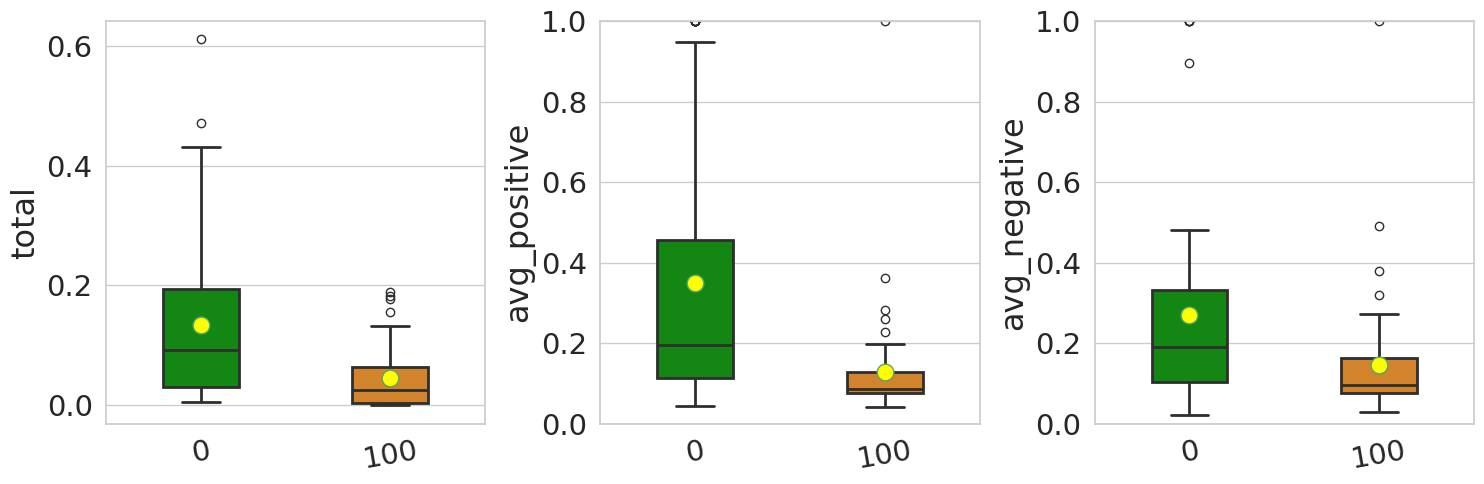

>>>>>> modules_count
experiment_name    reg10m2
Name: 0, dtype: object


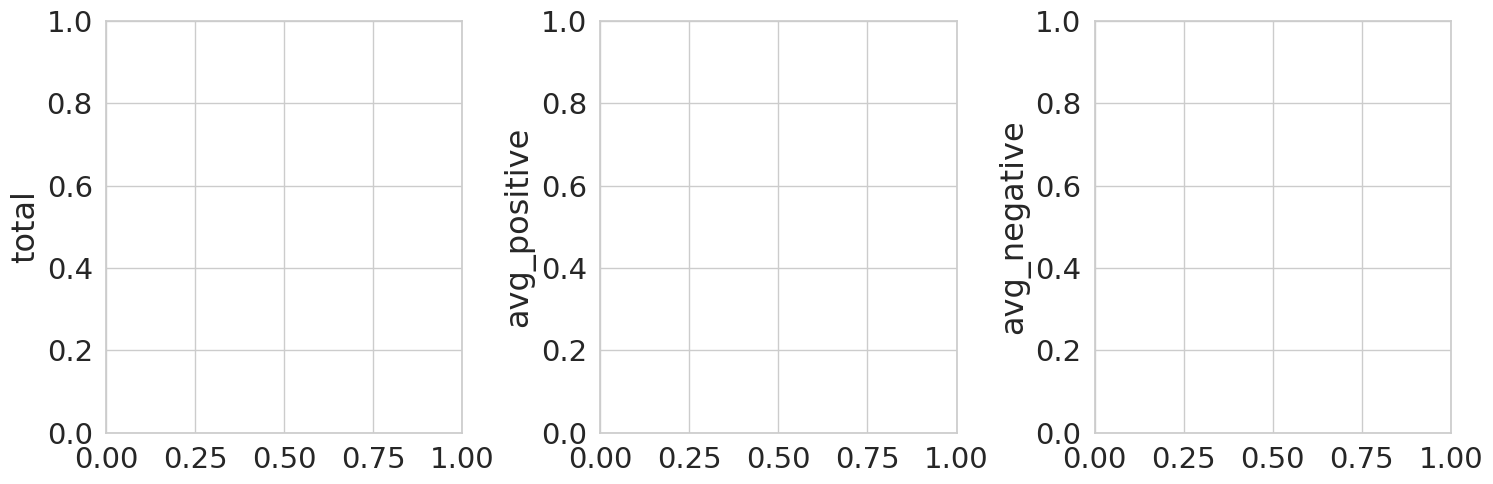

experiment_name    reg2m2
Name: 120, dtype: object


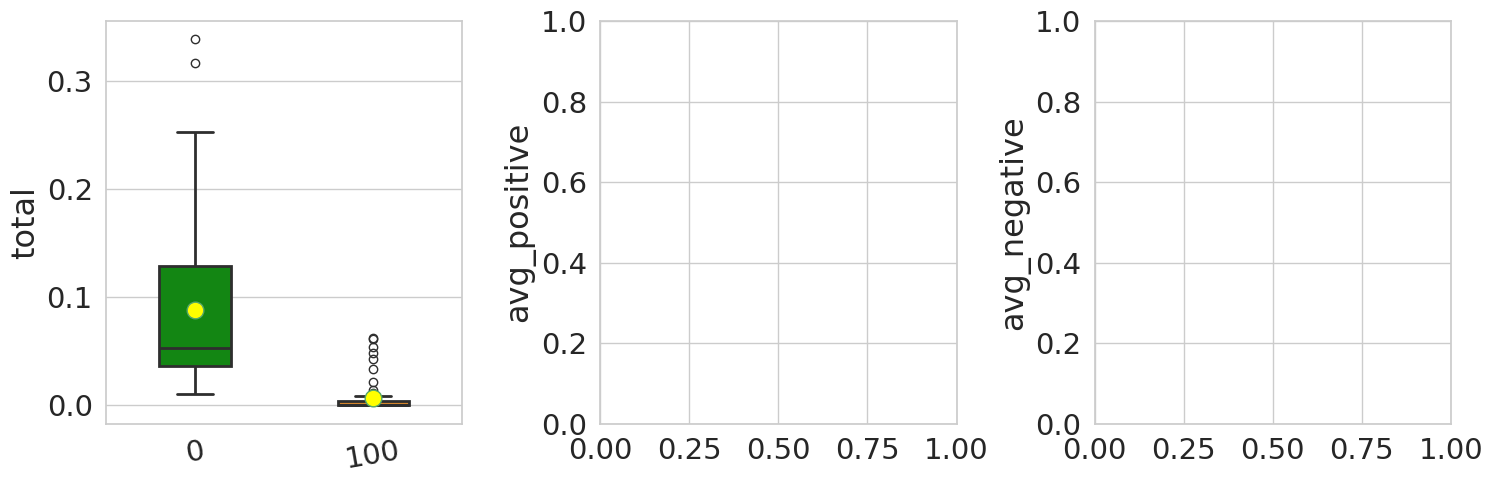

>>>>>> head_balance
experiment_name    reg10m2
Name: 0, dtype: object


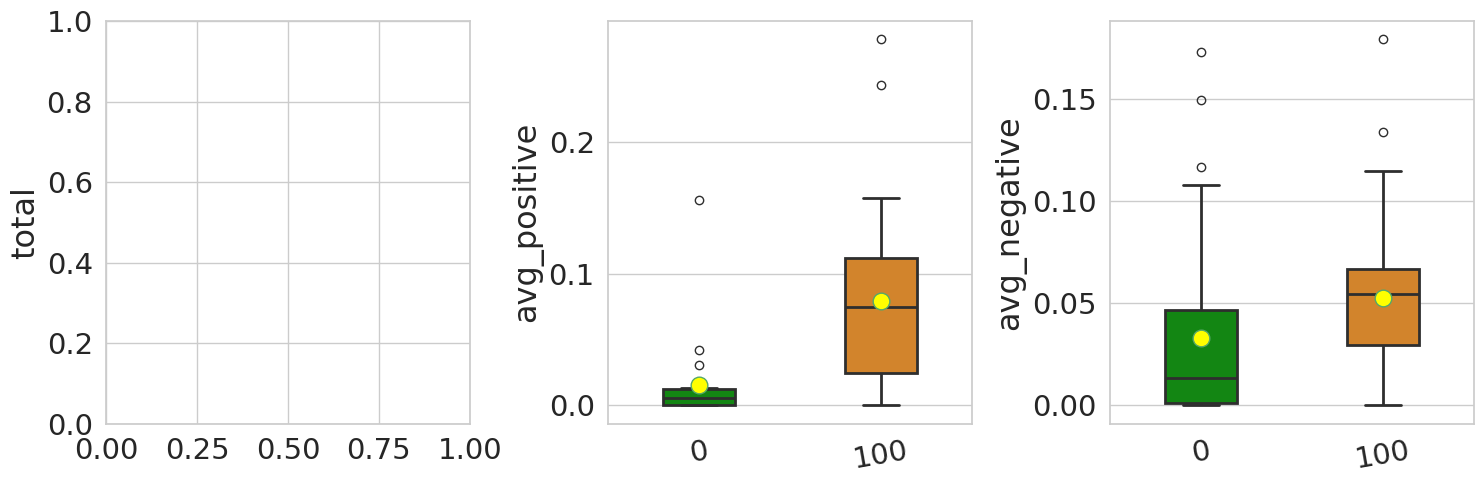

experiment_name    reg2m2
Name: 120, dtype: object


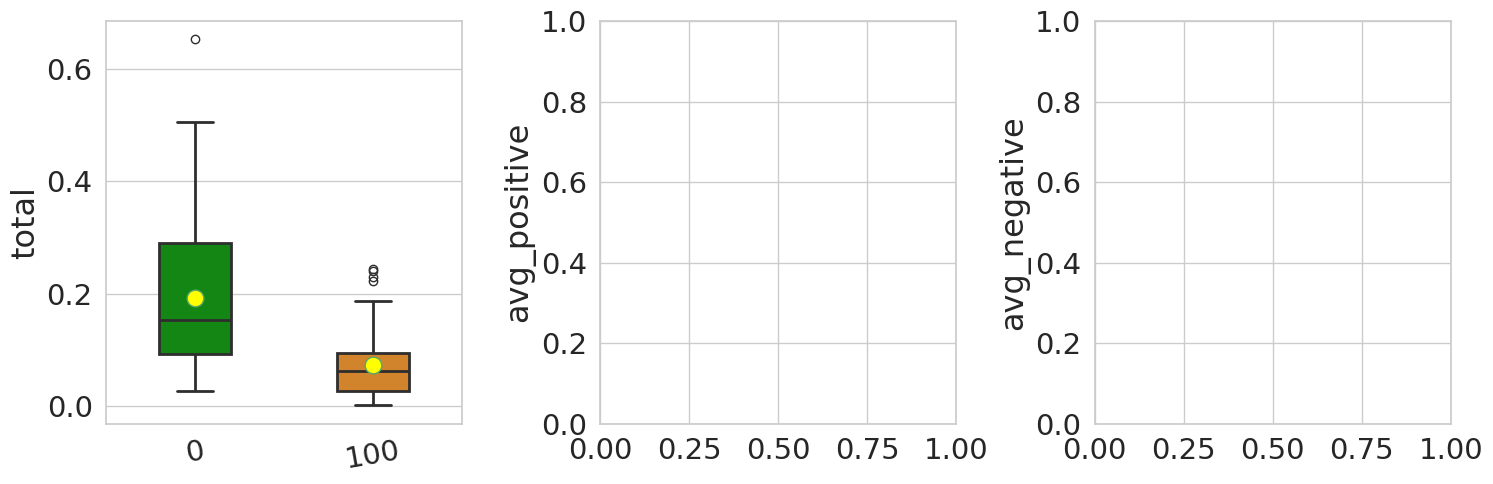

In [150]:
# boxes 

import seaborn as sb
from statannot import add_stat_annotation
from scipy.stats import mannwhitneyu
from scipy.stats import wilcoxon, ttest_ind
import warnings
warnings.filterwarnings('ignore')
# Set IPython to display all outputs
#InteractiveShell.ast_node_interactivity = "all"

avg_pos_scale = {'disp_y':4,'extremities_prop':1,'symmetry':1.15, 'coverage':0.65, 'hinge_prop':1}

avg_neg_scale = {'disp_y':-3.7,'extremities_prop':-1,'distance':-27, 'symmetry':-1.27, 'coverage':-0.69, 'hinge_prop':-1.05}

for trait in traits:
    print('>>>>>>',trait)
    
    df_trait = dfs_trait[trait]
    df_trait['avg_negative'] = df_trait['avg_negative'] * -1
    #display(df_trait)
    #f_trait = df_trait[ (df_trait['ranking'] == 'best') ]
    
    group_columns = ['experiment_name']#, 'ranking' ]
    unique_groups = df_trait[group_columns].drop_duplicates()
    filtered_dfs = {}
    
    for _, group in unique_groups.iterrows():
        print(group)
        # Filter rows based on the group
        filter_condition = (df_trait[group_columns] == group).all(axis=1)
        filtered_df = df_trait[filter_condition]
        group_key = tuple(group)
        filtered_dfs[group_key] = filtered_df
     
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))  
        sb.set(rc={"axes.titlesize": 23, "axes.labelsize": 23, 'ytick.labelsize': 21, 'xtick.labelsize': 21})
        sb.set_style("whitegrid")
        
        for idx, metric in enumerate(metrics):
            ax = axes[idx]

            filtered_clean = filtered_df[pd.notna(filtered_df[metric])]
            group1_data = filtered_clean[filtered_clean['gen'] == 0][f'{metric}']
            group2_data = filtered_clean[filtered_clean['gen'] == 100][f'{metric}']
           
            #_, p_value = wilcoxon(group1_data, group2_data)
            _, p_value = mannwhitneyu(group1_data, group2_data, alternative='two-sided')
            #print(f"\nMetric: {metric}, p-value: {round(p_value, 4)}")
            
            if p_value < 0.01:
               # display(filtered_clean[[metric, 'experiment_name',  'run',  'gen' ]])
              #  ax.text(0.5, max(filtered_clean[f'{metric}'].max()) + 0.1, f'p={p_value:.2f}', ha='center', va='bottom', fontsize=12)
                        
                sb.boxplot(x='gen', y=f'{metric}', data=filtered_clean,
                           palette=clrs, width=0.4, showmeans=True, linewidth=2, fliersize=6,
                           meanprops={"marker": "o", "markerfacecolor": "yellow", "markersize": "12"}, ax=ax)
                
                if metric in ['positive', 'negative']:
                    ax.set_ylim(0, 0.65)
    
                if metric == 'avg_positive' or metric == 'avg_negative':
                    if trait in avg_pos_scale.keys():
                        ax.set_ylim(0, avg_pos_scale[trait])
                # if metric == 'avg_negative':
                #     if trait in avg_pos_scale.keys():
                #         ax.set_ylim(avg_neg_scale[trait], 0)
          
                ax.tick_params(axis='x', labelrotation=10)
            
            ax.set_xlabel('')
            ax.set_ylabel(f'{metric}')
       
        plt.tight_layout()
        plt.show()

>>>>> disp_y
>>>>> extremities_prop
>>>>> distance
>>>>> symmetry
reg10m2
--
disp_y
extremities_prop
distance
symmetry


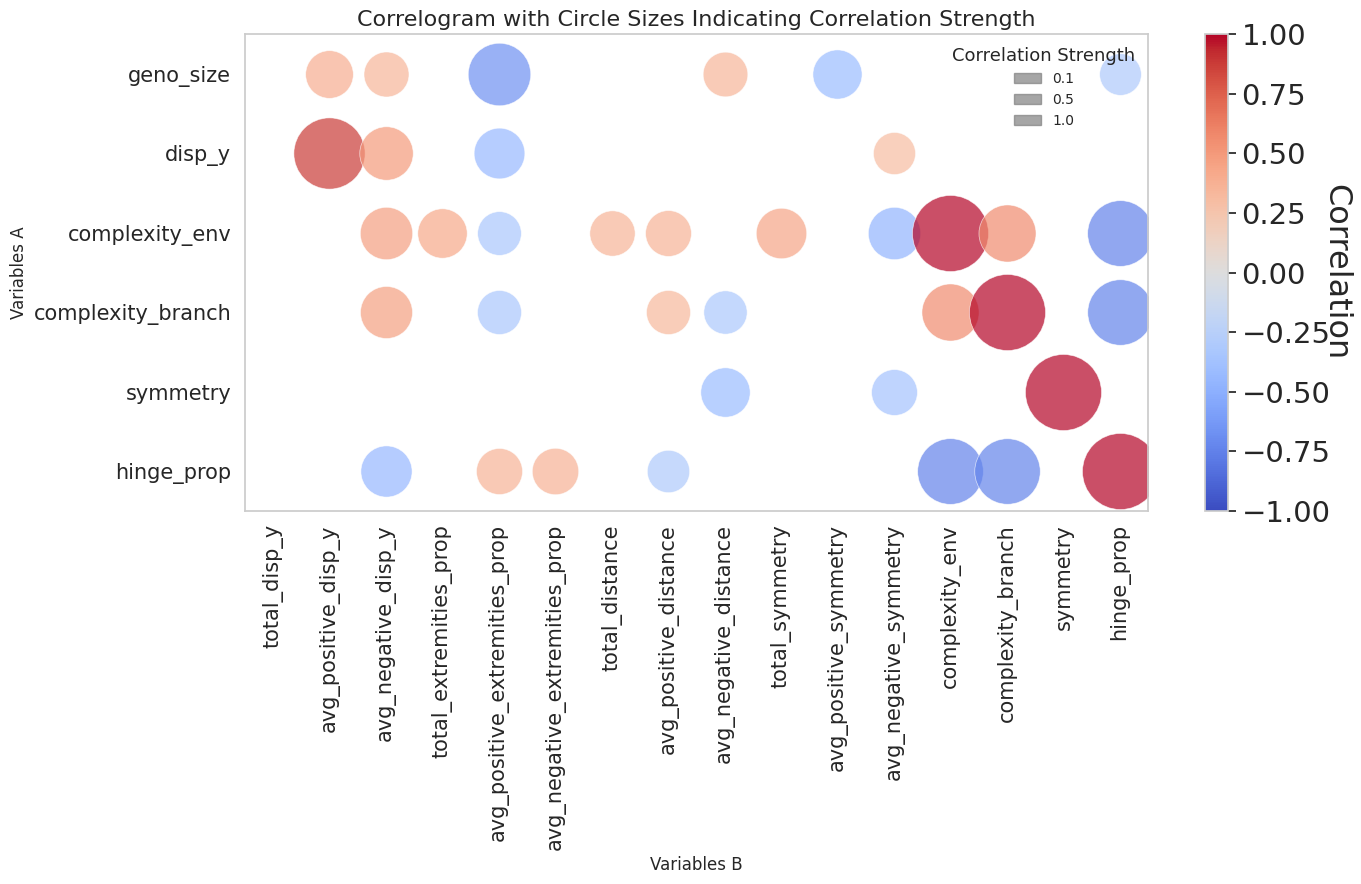

reg2m2
--
disp_y
extremities_prop
distance
symmetry


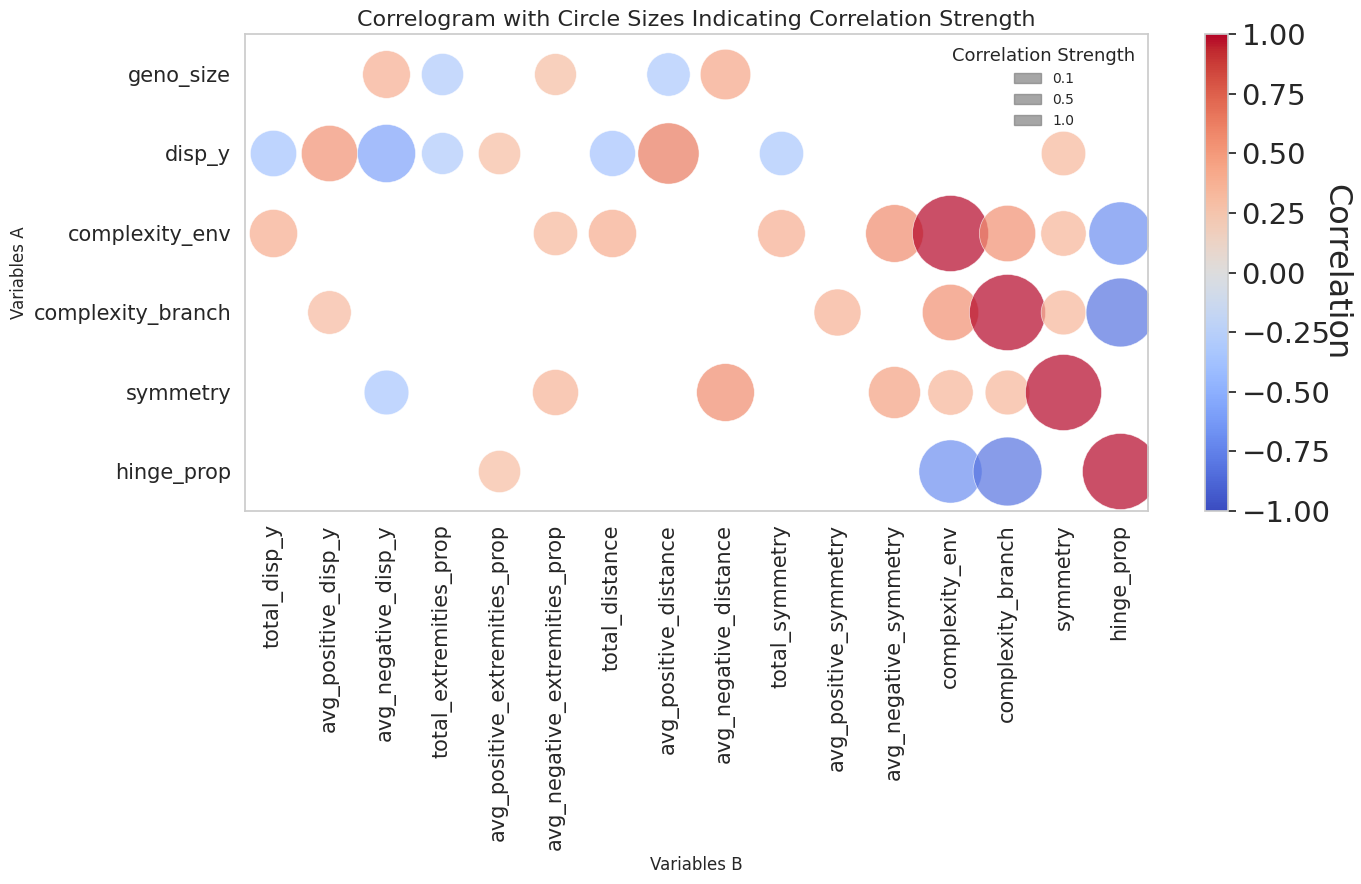

In [231]:
# corr

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from scipy.stats import pearsonr
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
# Suppress the specific pandas warning
pd.options.mode.chained_assignment = None 
pd.set_option('display.max_rows', 120)
pd.set_option('display.float_format', '{:.10f}'.format)

comp = pd.read_csv(f'../knockouts/comp.csv')
comp = comp.drop(columns=['disp_y', 'geno_size'])

traits = ['disp_y', 'extremities_prop', 'distance','symmetry']

dfs_trait={}
for trait in traits:
    print('>>>>>',trait)
    dfs_trait[trait] = pd.read_csv(f'effects_{trait}.csv')
    dfs_trait[trait]['total'] = dfs_trait[trait]['positive'] + dfs_trait[trait]['negative']
    



#traits = ['disp_y', 'extremities_prop', 'distance','symmetry','proportion','coverage','extensiveness_prop','hinge_prop','modules_count','head_balance']

com_metrics = ['complexity_env', 'complexity_branch', 'symmetry', 'hinge_prop']
corr_keys = ['experiment_name', 'run', 'gen', 'ranking', 'individual_id']
variables = ['geno_size', 'disp_y']

for exp in ['reg10m2', 'reg2m2']:
    print(exp)
    corr_df_all = pd.DataFrame()
        
    print('--')
    df_fit = df[(df['knockout'] == 'o')][corr_keys+['disp_y']]
    
    df_fit = pd.merge(df_fit, comp, on=corr_keys, how='inner')
    df_fit = df_fit[(df_fit['gen'] == 100)]
    #df_fit = df_fit[(df_fit['ranking'] == 'best')]

    metrics = []
    for idx,trait in enumerate(traits):
        print(trait)
        df_trait = dfs_trait[trait]
        df_trait['avg_negative'] = df_trait['avg_negative'] * -1
        df_trait = df_trait[(df_trait['experiment_name'] == exp) ]
      
        df_trait['total'] = df_trait['positive'] + df_trait['negative']
        
        corr_df = pd.merge(df_fit, df_trait, on=corr_keys, how='inner')
       
        corr_df = corr_df.sort_values(by='ranking')
        corr_df = corr_df.rename(columns={'total': 'total_'+trait, 
                                          'avg_positive': 'avg_positive_'+trait, 
                                          'avg_negative': 'avg_negative_'+trait})
        metrics.append('total_'+trait)
        metrics.append('avg_positive_'+trait)
        metrics.append('avg_negative_'+trait)
   
        if idx == 0:
            corr_df_all = corr_df
        else:
            corr_df = corr_df.drop(columns=['positive', 'neutral', 'negative', 'symmetry', 'hinge_prop',  'disp_y' ,'geno_size', 'Unnamed: 0', 'complexity_env', 'complexity_branch'])
            corr_df_all = pd.merge(corr_df_all, corr_df, on=corr_keys, how='inner')
    
   
    corr_matrix = corr_df_all[variables+metrics+com_metrics].corr()
    corr_matrix = corr_matrix.loc[variables+com_metrics, metrics+com_metrics]
   # display(corr_matrix)
    
#    print(corr_matrix)

    
    # Filter out correlations below the threshold
    threshold = 0.3
    filtered_corr_matrix = corr_matrix.copy()
    filtered_corr_matrix[abs(filtered_corr_matrix) < threshold] = np.nan
    
    # Create a figure
    fig, ax = plt.subplots(figsize=(14, 9))
    
    # Define color map and normalization
    cmap = plt.get_cmap('coolwarm')
    norm = plt.Normalize(vmin=-1, vmax=1)
   
    # Plot each circle based on the filtered correlation matrix
    for i, var_a in enumerate(filtered_corr_matrix.index):
        for j, var_b in enumerate(filtered_corr_matrix.columns):
            corr_value = filtered_corr_matrix.loc[var_a, var_b]
            if not np.isnan(corr_value):
                size = abs(corr_value) * 3000  # Scale size of the circle
                color = cmap(norm(corr_value))  # Map correlation to color (blue to red)
                
                # Plot a circle at the grid position
                ax.scatter(j, i, s=size, color=color, alpha=0.7, edgecolors='w', linewidth=0.5)
    
    # Set labels and title
    ax.set_xticks(range(len(filtered_corr_matrix.columns)))
    ax.set_yticks(range(len(filtered_corr_matrix.index)))
    ax.set_xticklabels(filtered_corr_matrix.columns, rotation=90, fontsize=15)  # Smaller font size
    ax.set_yticklabels(filtered_corr_matrix.index, fontsize=15)  # Smaller font size
    ax.set_xlabel('Variables B', size=12)
    ax.set_ylabel('Variables A', size=12)
    ax.set_title('Correlogram with Circle Sizes Indicating Correlation Strength', size=16)
    
    # Adjust the spacing between plot elements
    ax.set_xlim(-0.5, len(filtered_corr_matrix.columns) - 0.5)  # Ensure circles don't go out of bounds horizontally
    ax.set_ylim(len(filtered_corr_matrix.index) - 0.5, -0.5)   # Ensure circles don't go out of bounds vertically
    
    # Add color bar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=-1, vmax=1))
    cbar = plt.colorbar(sm)
    cbar.set_label('Correlation', rotation=270, labelpad=15)
    
    # Add size legend
    sizes = [100, 500, 1000]  # Sizes for the legend
    size_labels = [f'{size/1000:.1f}' for size in sizes]
    patches = [mpatches.Circle((0, 0), radius=np.sqrt(size/1000), color='grey', alpha=0.7) for size in sizes]
    ax.legend(patches, size_labels, title="Correlation Strength", title_fontsize='13', loc='upper right', fontsize='10', frameon=False)
    
    # Show the plot
    plt.grid(False)
    plt.tight_layout()
    plt.show()
    



                          disp_y  complexity_branch  complexity_env
experiment_name gen                                                
reg10m2         0   0.0052278205       2.5000000000    9.0000000000
                100 0.7400826267       1.2613636364   12.0000000000
reg2m2          0   0.0333074164       1.4285714286   12.0000000000
                100 1.6421453002       1.3452380952   14.5000000000
>>>>>> disp_y
0

Metric: disp_y, p-value: 0.8235


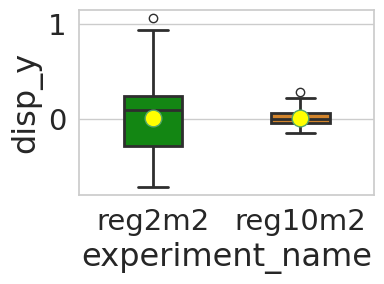

100

Metric: disp_y, p-value: 0.0844


<Figure size 640x480 with 0 Axes>

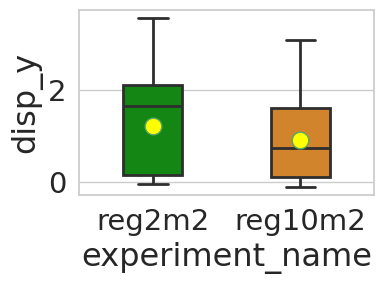

>>>>>> complexity_branch
0

Metric: complexity_branch, p-value: 0.0


<Figure size 640x480 with 0 Axes>

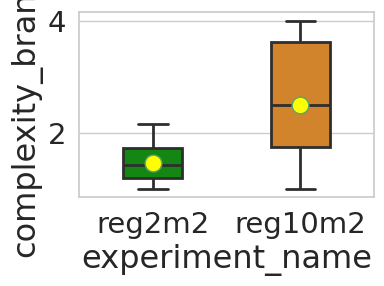

100

Metric: complexity_branch, p-value: 0.9151


<Figure size 640x480 with 0 Axes>

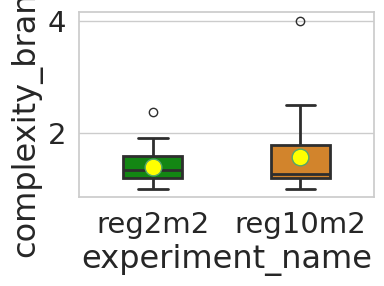

>>>>>> complexity_env
0

Metric: complexity_env, p-value: 0.0


<Figure size 640x480 with 0 Axes>

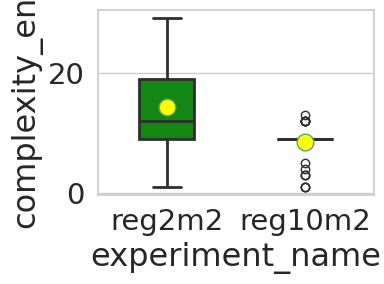

100

Metric: complexity_env, p-value: 0.0063


<Figure size 640x480 with 0 Axes>

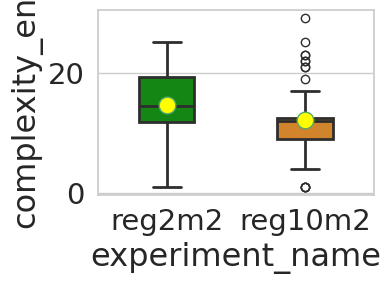

<Figure size 640x480 with 0 Axes>

In [70]:
from scipy.stats import mannwhitneyu
import warnings
warnings.filterwarnings('ignore')
import seaborn as sb
df_fit = df[(df['knockout'] == 'o')][corr_keys+['disp_y']]
df_comp = pd.merge(df_fit, comp, on=corr_keys, how='inner')

grouped = df_comp.groupby(['experiment_name', 'gen'])

avg_df = grouped.agg({
    'disp_y': 'median',
    'complexity_branch': 'median',
    'complexity_env': 'median'
})

print(avg_df)

traits = ['disp_y', 'complexity_branch', 'complexity_env']
for idx,trait in enumerate(traits):
     
    # fig, axes = plt.subplots(1, 2, figsize=(15, 5))  
    # sb.set(rc={"axes.titlesize": 23, "axes.labelsize": 23, 'ytick.labelsize': 21, 'xtick.labelsize': 21})
    # sb.set_style("whitegrid")
    # ax = axes[idx]
    print('>>>>>>',trait)
    for gen in [0,100]:
        print(gen)
        df_comp_g = df_comp[ (df_comp['gen'] == gen)]
        #df_comp_g = df_comp
    
        filtered_clean = df_comp_g[pd.notna(df_comp_g[trait])]
        group1_data = filtered_clean[filtered_clean['experiment_name'] == 'reg2m2'][f'{trait}']
        group2_data = filtered_clean[filtered_clean['experiment_name'] == 'reg10m2'][f'{trait}']
       
        #_, p_value = wilcoxon(group1_data, group2_data)
        _, p_value = mannwhitneyu(group1_data, group2_data, alternative='two-sided')
        print(f"\nMetric: {trait}, p-value: {round(p_value, 4)}")
        
        plt.figure(figsize=(4, 3))
        sb.boxplot(x='experiment_name', y=f'{trait}', data=df_comp_g,
                   palette=clrs, width=0.4, showmeans=True, linewidth=2, fliersize=6,
                   meanprops={"marker": "o", "markerfacecolor": "yellow", "markersize": "12"})#, ax=ax)
        
    
    
        ax.tick_params(axis='x', labelrotation=10)
        
        ax.set_xlabel('')
        ax.set_ylabel(f'{trait}')
    
        plt.tight_layout()
        plt.show()
        plt.clf()

In [ ]:
# geno size

from scipy.stats import pearsonr
pd.set_option('display.max_rows', 120)
pd.set_option('display.float_format', '{:.10f}'.format)

corr_keys = ['experiment_name', 'run', 'gen', 'ranking', 'individual_id']
variables = ['geno_size', 'disp_y']

for metric in ['total', 'avg_positive', 'avg_negative']:

    print('--')
    df_fit = df[(df['knockout'] == 'o')][corr_keys+['disp_y']]
    df_fit = df_fit[(df_fit['gen'] == 100)]

    for trait in traits:
       
       #for exp in ['reg2m2','reg10m2']:
        df_trait = dfs_trait[trait]
       
        df_trait = df_trait[(df_trait['experiment_name'] == 'reg2m2') ]
      
        df_trait['total'] = df_trait['positive'] + df_trait['negative']
        corr_df = pd.merge(df_fit, df_trait, on=corr_keys, how='inner')
        corr_df = corr_df.sort_values(by='ranking')
        display(corr_df)
        corr_df_tmp = corr_df[pd.notna(corr_df[metric])]
        corr_df_tmp = corr_df_tmp[pd.notna(corr_df_tmp[var])]
        
       # correlation_coefficient, p_value = pearsonr(corr_df_tmp[var], corr_df_tmp[metric])

        # if p_value < 0.05:
        #     print('\n', var, trait,metric)
        #     print(f"Pearson Correlation Coefficient: {correlation_coefficient}")
        #     print(f"P-value: {p_value}")
print('========')


In [ ]:
# OLD
for trait in traits:
    df = pd.read_csv(f'effects_{trait}.csv')

    grouped = df.groupby(['experiment_name', 'gen', 'ranking'])
    stats = []

    grouped = df.groupby(keys)
    results = []
    
    for var in metrics:
        median = grouped[var].median().rename('median')
        q1 = grouped[var].quantile(0.25).rename('Q1')
        q3 = grouped[var].quantile(0.75).rename('Q3')
        
#         mean = grouped[var].mean().rename('mean')
#         std = grouped[var].std().rename('std')

        stats = pd.concat([median, q1, q3], axis=1).reset_index()
        #stats = pd.concat([mean, std], axis=1).reset_index()
        stats['variable'] = var

        results.append(stats)

    final_stats_df = pd.concat(results, ignore_index=True)

    group_columns = ['experiment_name', 'ranking' ]
    unique_groups = final_stats_df[group_columns].drop_duplicates()

    filtered_dfs = {}

    for _, group in unique_groups.iterrows():
        # Filter rows based on the group
        filter_condition = (final_stats_df[group_columns] == group).all(axis=1)
        filtered_df = final_stats_df[filter_condition]
        group_key = tuple(group)
        filtered_dfs[group_key] = filtered_df

        font = {'font.size': 20}
        plt.rcParams.update(font)
        fig, ax = plt.subplots()

        plt.xlabel('')
        plt.ylabel(f' ')

        for idx,metric in enumerate(metrics):

            curve = filtered_df[filtered_df['variable'] == metric]
            print(curve)

           # ax.plot(curve['gen'], curve[f'mean'],  label=f'{metric}',  c=clrs[idx])
            ax.plot(curve['gen'], curve[f'median'],  label=f'{metric}',  c=clrs[idx])
           # ax.fill_between(curve['gen'],  curve[f'mean']-curve[f'std'],   curve[f'mean']+curve[f'std'],    alpha=0.3, facecolor=clrs[idx])
            ax.fill_between(curve['gen'],  curve[f'Q1'],  curve[f'Q3'],    alpha=0.3, facecolor=clrs[idx])
            ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),  fancybox=True, shadow=True, ncol=5, fontsize=10)


        plt.show()    

    #     plt.savefig(f'{group_key}_{trait}.png', bbox_inches='tight')
    #     plt.clf()
#     plt.close(fig)

                        

>>>>>> complexity_branch
reg2m2
1.711541633747516 1.4087559662559663

Metric: complexity_branch, p-value: 0.5479


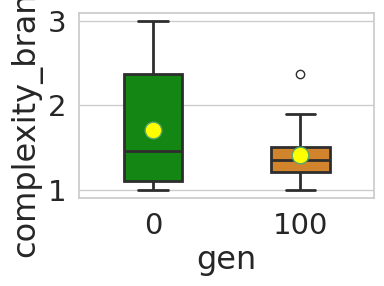

reg10m2
1.6696428571428572 1.4375524475524477

Metric: complexity_branch, p-value: 0.0142


<Figure size 640x480 with 0 Axes>

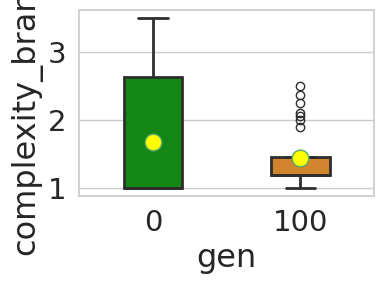

>>>>>> complexity_env
reg2m2
3.033333333333333 14.833333333333334

Metric: complexity_env, p-value: 0.0


<Figure size 640x480 with 0 Axes>

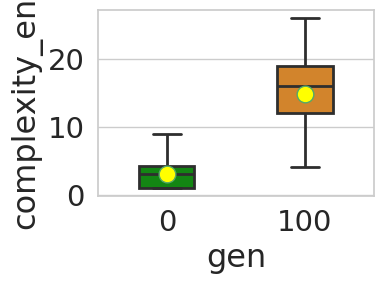

reg10m2
1.0 13.066666666666666

Metric: complexity_env, p-value: 0.0


<Figure size 640x480 with 0 Axes>

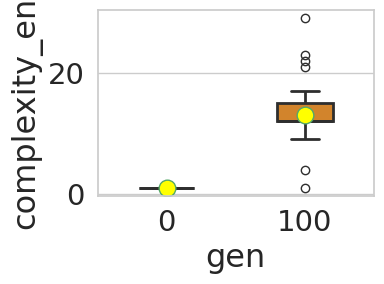

-------
>>>>>> complexity_branch
0
1.711541633747516 1.6696428571428572

Metric: complexity_branch, p-value: 0.0514


<Figure size 640x480 with 0 Axes>

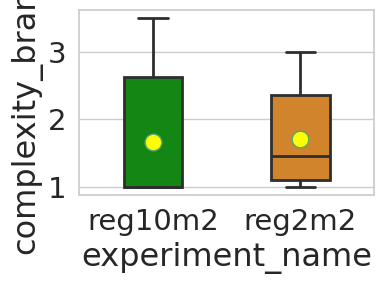

100
1.4087559662559663 1.4375524475524477

Metric: complexity_branch, p-value: 0.2306


<Figure size 640x480 with 0 Axes>

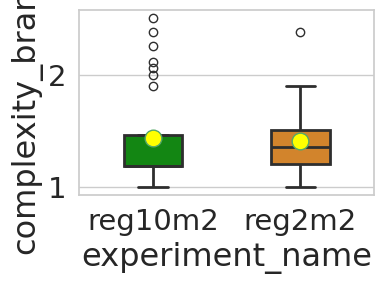

>>>>>> complexity_env
0
3.033333333333333 1.0

Metric: complexity_env, p-value: 0.0


<Figure size 640x480 with 0 Axes>

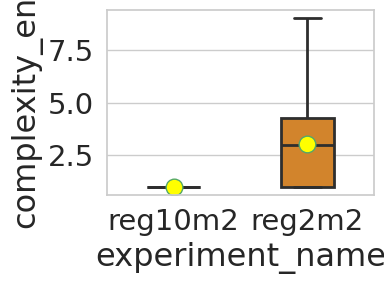

100
14.833333333333334 13.066666666666666

Metric: complexity_env, p-value: 0.1116


<Figure size 640x480 with 0 Axes>

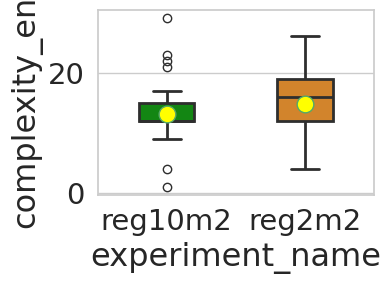

                   complexity_branch  complexity_env        disp_y
complexity_branch       1.0000000000    0.6114749430 -0.0785603047
complexity_env          0.6114749430    1.0000000000 -0.0831613996
disp_y                 -0.0785603047   -0.0831613996  1.0000000000


<Figure size 640x480 with 0 Axes>

In [86]:

   
# geno size and complexity curves, boxes, and corrs

import seaborn as sb
from scipy.stats import mannwhitneyu
from scipy.stats import wilcoxon
import warnings
warnings.filterwarnings('ignore')
import sys

clrs = ['#009900',
        '#EE8610',
        ]

comp = pd.read_csv(f'../knockout/comp.csv')
geno = pd.read_csv(f'../geno/genosize.csv')
geno = geno.drop(columns=['disp_y'])

comp['disp_y'] = pd.to_numeric(comp['disp_y'], errors='coerce')
    
corr_keys = ['experiment_name', 'run', 'gen', 'individual_id']
geno_comp = pd.merge(geno, comp, on=corr_keys, how='inner')
comp.replace([np.inf, -np.inf], np.nan, inplace=True)

grouped = comp.groupby(['experiment_name', 'gen', 'run'])
avg_comp = grouped.agg({
    'disp_y': 'median',
    'complexity_branch': 'median',
    'complexity_env': 'median'
})
avg_comp = avg_comp.reset_index()

traits = ['complexity_branch', 'complexity_env']
exps = ['reg2m2', 'reg10m2']
#display(avg_comp)

for idx,trait in enumerate(traits):
     
    print('>>>>>>',trait)
    for exp in exps:
        print(exp)
        df_comp_g = avg_comp[ (avg_comp['experiment_name'] == exp)]
    
        filtered_clean = df_comp_g[pd.notna(df_comp_g[trait])]
        group1_data = filtered_clean[filtered_clean['gen'] == 0][f'{trait}']
        group2_data = filtered_clean[filtered_clean['gen'] == 100][f'{trait}']
        print(group1_data.mean(), group2_data.mean())
        # _, p_value = wilcoxon(group1_data, group2_data)
        _, p_value = mannwhitneyu(group1_data, group2_data, alternative='two-sided')
        print(f"\nMetric: {trait}, p-value: {round(p_value, 4)}")
        
        plt.figure(figsize=(4, 3))
        sb.boxplot(x='gen', y=f'{trait}', data=df_comp_g,
                   palette=clrs, width=0.4, showmeans=True, linewidth=2, fliersize=6,
                   meanprops={"marker": "o", "markerfacecolor": "yellow", "markersize": "12"})#, ax=ax)
    
        plt.tight_layout()
        plt.show()
        plt.clf()







        
print('-------')
for idx,trait in enumerate(traits):
     
    print('>>>>>>',trait)
    for gen in [0, 100]:
        print(gen)
        df_comp_g = avg_comp[ (avg_comp['gen'] == gen)]
    
        filtered_clean = df_comp_g[pd.notna(df_comp_g[trait])]
        group1_data = filtered_clean[filtered_clean['experiment_name'] == 'reg2m2'][f'{trait}']
        group2_data = filtered_clean[filtered_clean['experiment_name'] == 'reg10m2'][f'{trait}']
        print(group1_data.mean(), group2_data.mean())
        # _, p_value = wilcoxon(group1_data, group2_data)
        _, p_value = mannwhitneyu(group1_data, group2_data, alternative='two-sided')
        
        print(f"\nMetric: {trait}, p-value: {round(p_value, 4)}")
        
        plt.figure(figsize=(4, 3))
        sb.boxplot(x='experiment_name', y=f'{trait}', data=df_comp_g,
                   palette=clrs, width=0.4, showmeans=True, linewidth=2, fliersize=6,
                   meanprops={"marker": "o", "markerfacecolor": "yellow", "markersize": "12"})#, ax=ax)
    
        plt.tight_layout()
        plt.show()
        plt.clf()
      
    








 >>>>>> complexity_branch
reg2m2
1.711541633747516 1.4087559662559663

Metric: complexity_branch, p-value: 0.5479


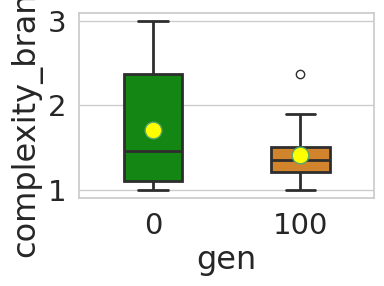

reg10m2
1.6696428571428572 1.4375524475524477

Metric: complexity_branch, p-value: 0.0142


<Figure size 640x480 with 0 Axes>

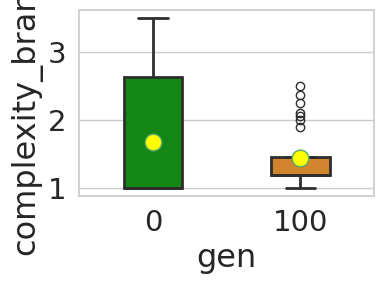


 >>>>>> complexity_env
reg2m2
3.033333333333333 14.833333333333334

Metric: complexity_env, p-value: 0.0


<Figure size 640x480 with 0 Axes>

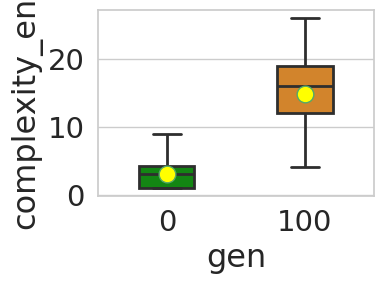

reg10m2
1.0 13.066666666666666

Metric: complexity_env, p-value: 0.0


<Figure size 640x480 with 0 Axes>

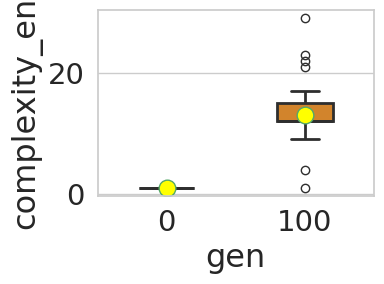

-------
>>>>>> complexity_branch
0
1.711541633747516 1.6696428571428572

Metric: complexity_branch, p-value: 0.0514


<Figure size 640x480 with 0 Axes>

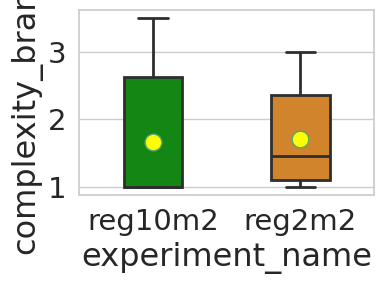

100
1.4087559662559663 1.4375524475524477

Metric: complexity_branch, p-value: 0.2306


<Figure size 640x480 with 0 Axes>

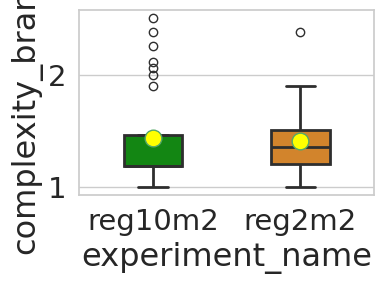

>>>>>> complexity_env
0
3.033333333333333 1.0

Metric: complexity_env, p-value: 0.0


<Figure size 640x480 with 0 Axes>

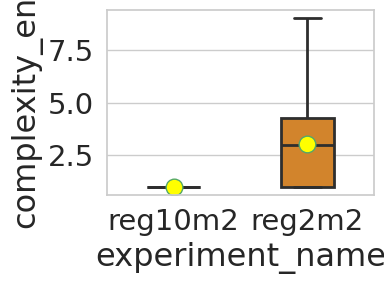

100
14.833333333333334 13.066666666666666

Metric: complexity_env, p-value: 0.1116


<Figure size 640x480 with 0 Axes>

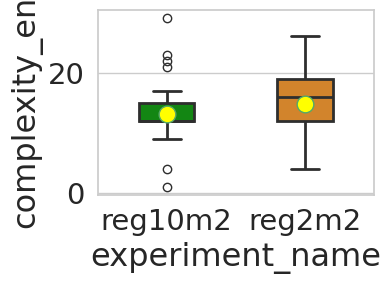

<Figure size 640x480 with 0 Axes>

In [93]:

   
# geno size and complexity curves, boxes, and corrs

import seaborn as sb
from scipy.stats import mannwhitneyu
from scipy.stats import wilcoxon
import warnings
warnings.filterwarnings('ignore')
import sys

clrs = ['#009900',
        '#EE8610',
        ]

comp = pd.read_csv(f'../comp/comp.csv')
geno = pd.read_csv(f'../geno/genosize.csv')
geno = geno.drop(columns=['disp_y'])

comp['disp_y'] = pd.to_numeric(comp['disp_y'], errors='coerce')
    
corr_keys = ['experiment_name', 'run', 'gen', 'individual_id']
geno_comp = pd.merge(geno, comp, on=corr_keys, how='inner')
comp.replace([np.inf, -np.inf], np.nan, inplace=True)

grouped = comp.groupby(['experiment_name', 'gen', 'run'])
avg_comp = grouped.agg({
    'disp_y': 'median',
    'complexity_branch': 'median',
    'complexity_env': 'median'
})
avg_comp = avg_comp.reset_index()

traits = ['complexity_branch', 'complexity_env']
vars = ['disp_y', 'genosize']
exps = ['reg2m2', 'reg10m2']



for idx,trait in enumerate(traits):
     
    print('\n >>>>>>',trait)
    for exp in exps:
        print(exp)
        df_comp_g = avg_comp[ (avg_comp['experiment_name'] == exp)]
    
        filtered_clean = df_comp_g[pd.notna(df_comp_g[trait])]
        group1_data = filtered_clean[filtered_clean['gen'] == 0][f'{trait}']
        group2_data = filtered_clean[filtered_clean['gen'] == 100][f'{trait}']
        
        print(group1_data.mean(), group2_data.mean())
        # _, p_value = wilcoxon(group1_data, group2_data)
        _, p_value = mannwhitneyu(group1_data, group2_data, alternative='two-sided')
        print(f"\nMetric: {trait}, p-value: {round(p_value, 4)}")
        
        plt.figure(figsize=(4, 3))
        sb.boxplot(x='gen', y=f'{trait}', data=df_comp_g,
                   palette=clrs, width=0.4, showmeans=True, linewidth=2, fliersize=6,
                   meanprops={"marker": "o", "markerfacecolor": "yellow", "markersize": "12"})#, ax=ax)
    
        plt.tight_layout()
        plt.show()
        plt.clf()


        
print('-------')
for idx,trait in enumerate(traits):
     
    print('>>>>>>',trait)
    for gen in [0, 100]:
        print(gen)
        df_comp_g = avg_comp[ (avg_comp['gen'] == gen)]
    
        filtered_clean = df_comp_g[pd.notna(df_comp_g[trait])]
        group1_data = filtered_clean[filtered_clean['experiment_name'] == 'reg2m2'][f'{trait}']
        group2_data = filtered_clean[filtered_clean['experiment_name'] == 'reg10m2'][f'{trait}']
        print(group1_data.mean(), group2_data.mean())
        # _, p_value = wilcoxon(group1_data, group2_data)
        _, p_value = mannwhitneyu(group1_data, group2_data, alternative='two-sided')
        
        print(f"\nMetric: {trait}, p-value: {round(p_value, 4)}")
        
        plt.figure(figsize=(4, 3))
        sb.boxplot(x='experiment_name', y=f'{trait}', data=df_comp_g,
                   palette=clrs, width=0.4, showmeans=True, linewidth=2, fliersize=6,
                   meanprops={"marker": "o", "markerfacecolor": "yellow", "markersize": "12"})#, ax=ax)
    
        plt.tight_layout()
        plt.show()
        plt.clf()
      
    

complexity_branch

 >>>>>> reg2m2 25
Average of 'b' in the first half: 1.626644237913816
Average of 'b' in the second half: 1.5868063685306468
  p-value: 0.1602


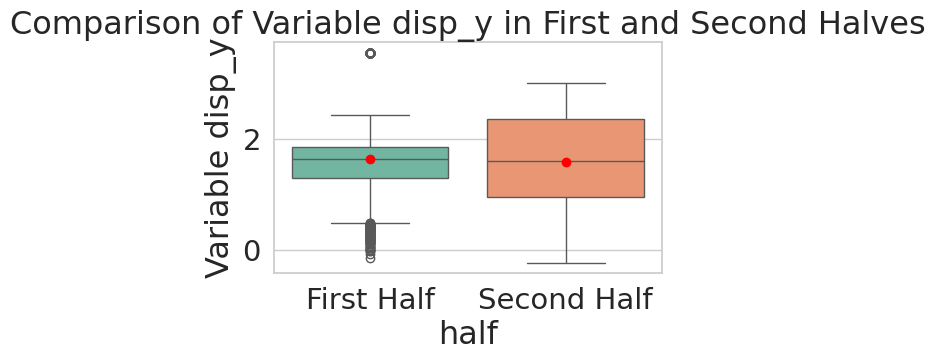


 >>>>>> reg10m2 25
Average of 'b' in the first half: 1.406815936769739
Average of 'b' in the second half: 1.196804115681678
  p-value: 0.0


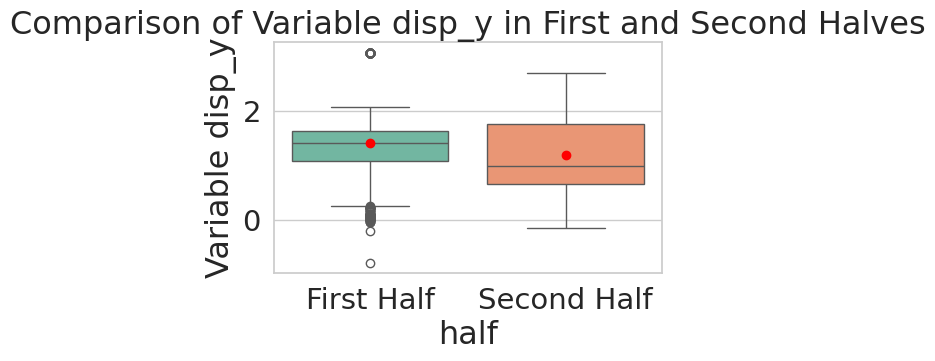

complexity_env

 >>>>>> reg2m2 25
Average of 'b' in the first half: 1.6995799987068057
Average of 'b' in the second half: 1.5139193290207522
  p-value: 0.0


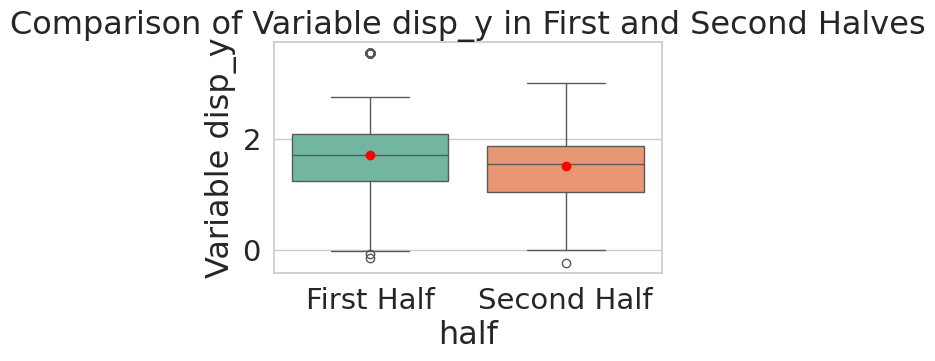


 >>>>>> reg10m2 25
Average of 'b' in the first half: 1.246080022095698
Average of 'b' in the second half: 1.357540030355719
  p-value: 0.0


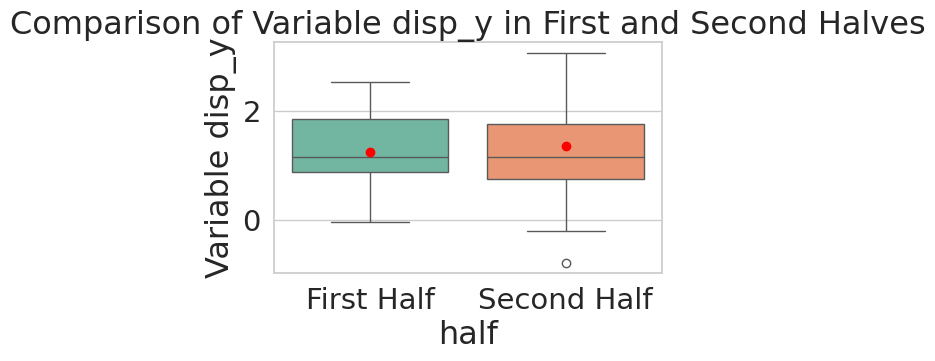

In [200]:

# TODO: include gen 100, export genosize with comp

# geno size and complexity curves, boxes, and corrs

import seaborn as sb
from scipy.stats import mannwhitneyu
from scipy.stats import wilcoxon
import warnings
warnings.filterwarnings('ignore')
import sys
import itertools
clrs = ['#009900',
        '#EE8610',
        ]

comp = pd.read_csv(f'../knockouts/comp.csv')
geno = pd.read_csv(f'../geno/genosize.csv')
geno = geno.drop(columns=['disp_y'])

comp['disp_y'] = pd.to_numeric(comp['disp_y'], errors='coerce')
comp.replace([np.inf, -np.inf], np.nan, inplace=True)
    
corr_keys = ['experiment_name', 'run', 'gen', 'individual_id']
geno_comp = pd.merge(geno, comp, on=corr_keys, how='inner')

   
traits = ['complexity_branch', 'complexity_env', 'disp_y', 'geno_size']
pairs = list(itertools.combinations(traits, 2))

exps = ['reg2m2', 'reg10m2']

# for gen in [25]:
#     for exp in exps:
#         df_comp_g = geno_comp[ (geno_comp['experiment_name'] == exp) & (geno_comp['gen'] == gen)]
#         #display(df_comp_g)      

#         for pair in pairs:

#             filtered_clean = df_comp_g[pd.notna(df_comp_g[pair[0]]) & pd.notna(df_comp_g[pair[1]])]
       
#             #display(filtered_clean)      
#             print('\n  ', exp, gen, pair[0],pair[1])
#             correlation_coefficient, p_value = pearsonr(filtered_clean[pair[0]], filtered_clean[pair[1]])
#             if p_value < 0.05:
#               #  print('\n >>>>>>',exp, gen)
#                 print(f"Pearson Correlation Coefficient: {correlation_coefficient}")
#                 print(f"P-value: {p_value}")
                
    

compvars = ['complexity_branch','complexity_env']
for compvar in compvars:
    print(compvar)
    for exp in exps:
        print('\n >>>>>>',exp, gen)
       # display(geno_comp)
        df_comp_g = geno_comp[ (geno_comp['experiment_name'] == exp) & (geno_comp['gen']  == 99)  ]
         
        df_comp_g = df_comp_g.replace([np.inf, -np.inf], np.nan).dropna()
        df_sorted = df_comp_g.sort_values(by=compvar).reset_index(drop=True)
    
        # Step 2: Divide the DataFrame into two parts (first half and second half)
        midpoint = len(df_sorted) // 2
        first_half = df_sorted.iloc[:midpoint]
        second_half = df_sorted.iloc[midpoint:]
    
        # Step 4: Calculate and display the averages for 'b' in each half
        avg_first_half = first_half['disp_y'].mean()
        avg_second_half = second_half['disp_y'].mean()
        
        print(f"Average of 'b' in the first half: {avg_first_half}")
        print(f"Average of 'b' in the second half: {avg_second_half}")
        t_stat, p_value = ttest_ind(first_half['disp_y'], second_half['disp_y'], equal_var=False)

        #_, p_value = mannwhitneyu(first_half['disp_y'], second_half['disp_y'], alternative='two-sided')
        print(f"  p-value: {round(p_value, 4)}")
                        
    
        
         
        # plt.figure(figsize=(10, 6))
        # sns.boxplot(data=[first_half['disp_y'], second_half['disp_y']], palette="Set2")
        # plt.xticks([0, 1], ['First Half', 'Second Half'])
        # plt.title('Comparison of Variable b in First and Second Halves')
        # plt.ylabel('Variable b')
        # plt.show()

        # Step 4: Add a new column to each half to indicate "First Half" or "Second Half"
        first_half['half'] = 'First Half'
        second_half['half'] = 'Second Half'
        
        # Step 5: Concatenate the two halves back into a single DataFrame
        df_concat = pd.concat([first_half, second_half], ignore_index=True)
        #display(df_concat)
        
        # Step 6: Plot variable 'disp_y' for each half using box plots
        plt.figure(figsize=(5, 3))
        sns.boxplot(x='half', y='disp_y', data=df_concat, palette="Set2")

        plt.scatter(x=[0], y=[avg_first_half], color='red', label='Mean', zorder=5)
        plt.scatter(x=[1], y=[avg_second_half], color='red', zorder=5)

        plt.title('Comparison of Variable disp_y in First and Second Halves')
        plt.ylabel('Variable disp_y')
        plt.show()





In [ ]:
# boxes per run clusters / OLD?

traits = ['disp_y', 'distance', 'proportion','coverage']
dfs_trait={}
for trait in traits:
    print('>>>>>>',trait)
    
    dfs_trait[trait] = pd.read_csv(f'effects_{trait}.csv')
   

# best  
import seaborn as sb
from statannot import add_stat_annotation
from scipy.stats import wilcoxon, ttest_ind


best_robots = df_ori[(df_ori['knockout'] == 'o' ) & (df_ori['ranking'] == 'best' ) & (df_ori['gen'] == 100 )]
best_robots = best_robots.sort_values(by=['experiment_name', 'disp_y'], ascending=[False, False])
best_robots = best_robots[['experiment_name', 'run', 'gen', 'ranking', 'disp_y']]
exps = ['reg2m2', 'reg10m2']
n_runs = 30

for trait in traits:
    print('>>>>>>',trait)
    for exp in exps:
        print(exp)
        half = int(n_runs/2)
        best_run = best_robots[(best_robots['experiment_name'] == exp )]['run'][0:half]
        worst_runs = best_robots[(best_robots['experiment_name'] == exp )]['run'][half:n_runs]
        
        for runs in [best_run, worst_runs]:

            df_trait=dfs_trait[trait]
            df_trait = df_trait[ (df_trait['experiment_name']  == exp)  & (df_trait['ranking']  == 'best') & df_trait['run'].isin(runs) ]
    
            fig, axes = plt.subplots(1, 4, figsize=(15, 5))  # Adjust figsize as needed
            sb.set(rc={"axes.titlesize": 10, "axes.labelsize": 10, 'ytick.labelsize': 10, 'xtick.labelsize': 10})
            sb.set_style("whitegrid")

            for idx, metric in enumerate(metrics):
                ax = axes[idx]

                if metric in ['avg_positive', 'avg_negative']:
                    filtered_clean = filtered_df[pd.notna(filtered_df[metric])]
                
                group1_data = filtered_clean[filtered_clean['gen'] == 0][f'{metric}']
                group2_data = filtered_clean[filtered_clean['gen'] == 100][f'{metric}']
    
                
                _, p_value = mannwhitneyu(group1_data, group2_data, alternative='two-sided')
                print(f"Metric: {metric}, p-value: {round(p_value, 4)}")
                
                if p_value < 0.05:
                        
                    sb.boxplot(x='gen', y=f'{metric}', data=df_trait,
                               palette=clrs, width=0.4, showmeans=True, linewidth=2, fliersize=6,
                               meanprops={"marker": "o", "markerfacecolor": "yellow", "markersize": "12"}, ax=ax)
                    
                    ax.tick_params(axis='x', labelrotation=10)
                    
                    ax.set_xlabel('')
                    ax.set_ylabel(f'{metric}')
            
            # Adjust layout to avoid overlap
            plt.tight_layout()
            plt.show()

In [ ]:
# boxes per run / 
traits = ['disp_y', 'extremities_prop', 'distance','symmetry','proportion','coverage','extensiveness_prop','hinge_prop','modules_count','head_balance']

dfs_trait={}
for trait in traits:
    print('>>>>>>',trait)
    
    dfs_trait[trait] = pd.read_csv(f'effects_{trait}.csv')
   

# best  
import seaborn as sb
from statannot import add_stat_annotation
from scipy.stats import wilcoxon, ttest_ind


for trait in traits:
    print('>>>>>>',trait)
    
    df_trait=dfs_trait[trait]
    df_trait = df_trait[ (df_trait['ranking'] == 'best') &  (df_trait['gen'] == 100) ]

       # Define the columns to use for grouping
    group_columns = ['experiment_name', 'ranking']

    # Find unique combinations of the specified columns
    unique_groups = df_trait[group_columns].drop_duplicates()

    filtered_dfs = {}
    
    
    
        #line
    # Iterate over each unique group
    for _, group in unique_groups.iterrows():
        # Filter rows based on the group
        filter_condition = (df_trait[group_columns] == group).all(axis=1)
        filtered_df = df_trait[filter_condition]

        # Use a tuple of group values as the key in the dictionary
        print(group)
        group_key = tuple(group)
        filtered_dfs[group_key] = filtered_df

        # Set up the subplots
        # fig, axes = plt.subplots(1, 4, figsize=(15, 5))  # Adjust figsize as needed
        # sb.set(rc={"axes.titlesize": 10, "axes.labelsize": 10, 'ytick.labelsize': 10, 'xtick.labelsize': 10})
        # sb.set_style("whitegrid")
       # print(filtered_df)
        # for idx, metric in enumerate(metrics):
        #     ax = axes[idx]
                    
        #     sb.boxplot(x='gen', y=f'{metric}', data=filtered_df,
        #                palette=clrs, width=0.4, showmeans=True, linewidth=2, fliersize=6,
        #                meanprops={"marker": "o", "markerfacecolor": "yellow", "markersize": "12"}, ax=ax)
            
        #     ax.tick_params(axis='x', labelrotation=10)
            
        #     ax.set_xlabel('')
        #     ax.set_ylabel(f'{metric}')
        
        # # Adjust layout to avoid overlap
        # plt.tight_layout()
        # plt.show()

In [ ]:
# boxes OLD?

# best
import seaborn as sb
from statannot import add_stat_annotation
from scipy.stats import wilcoxon, ttest_ind

for trait in traits:
    print('>>>>>>',trait)
    
    df_trait=dfs_trait[trait]

    group_columns = ['experiment_name', 'ranking' ]
    unique_groups = df_trait[group_columns].drop_duplicates()
    filtered_dfs = {}
    
    for _, group in unique_groups.iterrows():
        # Filter rows based on the group
        filter_condition = (df_trait[group_columns] == group).all(axis=1)
        filtered_df = df_trait[filter_condition]

        print(group)
        group_key = tuple(group)
        filtered_dfs[group_key] = filtered_df

        # Set up the subplots
        fig, axes = plt.subplots(1, 4, figsize=(15, 5))  # Adjust figsize as needed
        sb.set(rc={"axes.titlesize": 23, "axes.labelsize": 23, 'ytick.labelsize': 21, 'xtick.labelsize': 21})
        sb.set_style("whitegrid")
        
        for idx, metric in enumerate(metrics):
            ax = axes[idx]
            
            group1_data = filtered_df[filtered_df['gen'] == 0][f'{metric}']
            group2_data = filtered_df[filtered_df['gen'] == 100][f'{metric}']
           
            _, p_value = wilcoxon(group1_data, group2_data)
            print(f"Metric: {metric}, p-value: {round(p_value, 4)}")
            
            if p_value < 0.05:
                # Add text annotation for p-value
            #    ax.text(0.5, max(filtered_df[f'{metric}'].max()) + 0.1, f'p={p_value:.2f}', ha='center', va='bottom', fontsize=12)

                        
                sb.boxplot(x='gen', y=f'{metric}', data=filtered_df,
                           palette=clrs, width=0.4, showmeans=True, linewidth=2, fliersize=6,
                           meanprops={"marker": "o", "markerfacecolor": "yellow", "markersize": "12"}, ax=ax)
                
                ax.tick_params(axis='x', labelrotation=10)
            
            ax.set_xlabel('')
            ax.set_ylabel(f'{metric}')

        plt.tight_layout()
        plt.show()